In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json
import itertools
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import regex as re
import numpy as np
import math



# Factual

##Top-1


Werte 1-10 shots und Permutation Mittelwer +_ STD pro Relation


In [31]:
#top 1
import os, re, json
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_factual_accuracy(
        base_dirs: dict,
        title: str = "Englisch, Factual: Permutation-Mittel ± 1 STD pro Relation",
        groups: dict[str, list[str]] | None = None,
        full_shots: list[int] | None = None,
        fname="subplot_accuracy",
        save_dir=None
    ):
    """
    Plottet Top-1-Accuracy (Mittel ± 1 STD) über verschiedene Shot-Zahlen,
    gruppiert nach semantischen Relationstypen (4 Subplots).
    """

    # ------------------------------------------------------------
    # 0) Defaults
    # ------------------------------------------------------------
    if full_shots is None:
        full_shots = [0, 1, 2, 3, 4, 5, 7, 10]

    if groups is None:
        groups = OrderedDict({
            "Personenbezogene Fakten": [
                "person mother", "person father", "person occupation",
                "person plays instrument", "person university",
                "person lead singer of band",
                "person sport position", "plays pro sport",
                "superhero person"
            ],
            "Orts-/Länderbezogene Fakten": [
                "landmark on continent", "landmark in country",
                "country university", "food from country", "city in country",
                "country capital city", "country language",
                "country largest city", "country currency"
            ],
            "Unternehmens- & Produktbezogene Fakten": [
                "product by company", "company CEO", "company hq"
            ],
            "Historische/Zeit- & sonstige Fakten": [
                "president birth year", "president election year",
                "star constellation name", "pokemon evolution",
                "superhero archnemesis"
            ]
        })

    # ------------------------------------------------------------
    # 1) Alias-Tabelle
    # ------------------------------------------------------------
    ALIASES = {
        "person lead singer of band": "person_band_lead_singer",
        "person sport position":      "person_plays_position_in_sport",
        "plays pro sport":            "person_plays_pro_sport",
        "pokemon evolution":          "pokemon_evolutions",
        "president birth year":       "presidents_birth_year",
        "president election year":    "presidents_election_year",
        "star constellation name":    "star_constellation",
        "country capital city":       "country_capital_city",
        "country largest city":       "country_largest_city",
        "country language":           "country_language",
        "company CEO":                "company_ceo"
    }

    # ------------------------------------------------------------
    # 2) JSONs einlesen
    # ------------------------------------------------------------
    records = []
    for root in base_dirs.values():
        for rel_folder in os.listdir(root):
            rel_path = os.path.join(root, rel_folder)
            if not os.path.isdir(rel_path):
                continue
            relation = rel_folder.replace("accuracy_", "")
            for fn in os.listdir(rel_path):
                if not fn.endswith(".json"):
                    continue
                if re.search(r"\b0shot\b", fn, re.IGNORECASE):
                    continue
                m = re.search(r"(\d+)shot", fn, re.IGNORECASE)
                if not m:
                    continue
                shot = int(m.group(1))
                with open(os.path.join(rel_path, fn), encoding="utf-8") as f:
                    data = json.load(f)
                acc = data.get("top_1_accuracy") or data.get("average_top_1_accuracy")
                if acc is None:
                    continue
                records.append(dict(Relation=relation, Shot=shot, Accuracy=float(acc)))

    df = pd.DataFrame(records)
    if df.empty:
        raise ValueError("Keine gültigen 1-Shot…10-Shot-Dateien gefunden")

    stats = (
        df.groupby(["Relation", "Shot"])["Accuracy"]
          .agg(mean="mean", std="std")
          .reset_index()
    )
    available = set(stats["Relation"].unique())

    # ------------------------------------------------------------
    # 3) Resolver
    # ------------------------------------------------------------
    def resolve(rel: str) -> str | None:
        if rel in available:
            return rel
        alt = rel.replace(" ", "_") if " " in rel else rel.replace("_", " ")
        if alt in available:
            return alt
        alt = ALIASES.get(rel)
        if alt in available:
            return alt
        return None

    # ------------------------------------------------------------
    # 4) Plotten (gruppenspezifische Farbpaletten)
    # ------------------------------------------------------------
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for ax, (grp_title, rel_list) in zip(axes, groups.items()):
        cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))
        for idx_rel, rel in enumerate(rel_list):
            true_rel = resolve(rel)
            if true_rel is None:
                print(f"[INFO] Relation '{rel}' nicht in Daten gefunden – übersprungen.")
                continue

            sub = (stats[stats["Relation"] == true_rel]
                   .set_index("Shot")
                   .reindex(full_shots))
            mu, sig = sub["mean"], sub["std"]
            color = cmap_grp(idx_rel)

            ax.fill_between(full_shots, mu - sig, mu + sig,
                            color=color, alpha=0.3, linewidth=0, zorder=1)
            ax.plot(full_shots, mu, color=color, linewidth=2,
                    label=true_rel.replace("_", " "), zorder=2)

        ax.set_title(grp_title)
        ax.set_xticks(full_shots)
        ax.set_ylim(0, 105)
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)
        ax.legend(fontsize=8, loc='lower right')

    fig.text(0.5, 0.04, 'Shots', ha='center')
    fig.text(0.04, 0.5, 'Top-1 Accuracy (%)',
             va='center', rotation='vertical')
    fig.suptitle(title, fontsize=16)

    plt.tight_layout(rect=(0.04, 0, 1, 0.96))
    plt.show()
    # am Ende der plot_factual_accuracy-Funktion hinzufügen:

    if save_dir:
      os.makedirs(save_dir, exist_ok=True)
      fig.savefig(os.path.join(save_dir, f"{fname}.pdf"))
      fig.savefig(os.path.join(save_dir, f"{fname}.png"), dpi=300)






## Top-10

In [3]:
#top 10
import os, re, json
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_factual_accuracy_10(
        base_dirs: dict,
        title: str = "Englisch, Factual: Permutation-Mittel ± 1 STD pro Relation",
        groups: dict[str, list[str]] | None = None,
        full_shots: list[int] | None = None,
        fname="subplot_accuracy",
        save_dir=None
    ):
    """
    Plottet Top-1-Accuracy (Mittel ± 1 STD) über verschiedene Shot-Zahlen,
    gruppiert nach semantischen Relationstypen (4 Subplots).
    """

    # ------------------------------------------------------------
    # 0) Defaults
    # ------------------------------------------------------------
    if full_shots is None:
        full_shots = [0, 1, 2, 3, 4, 5, 7, 10]

    if groups is None:
        groups = OrderedDict({
            "Personenbezogene Fakten": [
                "person mother", "person father", "person occupation",
                "person plays instrument", "person university",
                "person lead singer of band",
                "person sport position", "plays pro sport",
                "superhero person"
            ],
            "Orts-/Länderbezogene Fakten": [
                "landmark on continent", "landmark in country",
                "country university", "food from country", "city in country",
                "country capital city", "country language",
                "country largest city", "country currency"
            ],
            "Unternehmens- & Produktbezogene Fakten": [
                "product by company", "company CEO", "company hq"
            ],
            "Historische/Zeit- & sonstige Fakten": [
                "president birth year", "president election year",
                "star constellation name", "pokemon evolution",
                "superhero archnemesis"
            ]
        })

    # ------------------------------------------------------------
    # 1) Alias-Tabelle
    # ------------------------------------------------------------
    ALIASES = {
        "person lead singer of band": "person_band_lead_singer",
        "person sport position":      "person_plays_position_in_sport",
        "plays pro sport":            "person_plays_pro_sport",
        "pokemon evolution":          "pokemon_evolutions",
        "president birth year":       "presidents_birth_year",
        "president election year":    "presidents_election_year",
        "star constellation name":    "star_constellation",
        "country capital city":       "country_capital_city",
        "country largest city":       "country_largest_city",
        "country language":           "country_language",
        "company CEO":                "company_ceo"
    }

    # ------------------------------------------------------------
    # 2) JSONs einlesen
    # ------------------------------------------------------------
    records = []
    for root in base_dirs.values():
        for rel_folder in os.listdir(root):
            rel_path = os.path.join(root, rel_folder)
            if not os.path.isdir(rel_path):
                continue
            relation = rel_folder.replace("accuracy_", "")
            for fn in os.listdir(rel_path):
                if not fn.endswith(".json"):
                    continue
                if re.search(r"\b0shot\b", fn, re.IGNORECASE):
                    continue
                m = re.search(r"(\d+)shot", fn, re.IGNORECASE)
                if not m:
                    continue
                shot = int(m.group(1))
                with open(os.path.join(rel_path, fn), encoding="utf-8") as f:
                    data = json.load(f)
                acc = data.get("top_10_accuracy") or data.get("average_top_10_accuracy")
                if acc is None:
                    continue
                records.append(dict(Relation=relation, Shot=shot, Accuracy=float(acc)))

    df = pd.DataFrame(records)
    if df.empty:
        raise ValueError("Keine gültigen 1-Shot…10-Shot-Dateien gefunden")

    stats = (
        df.groupby(["Relation", "Shot"])["Accuracy"]
          .agg(mean="mean", std="std")
          .reset_index()
    )
    available = set(stats["Relation"].unique())

    # ------------------------------------------------------------
    # 3) Resolver
    # ------------------------------------------------------------
    def resolve(rel: str) -> str | None:
        if rel in available:
            return rel
        alt = rel.replace(" ", "_") if " " in rel else rel.replace("_", " ")
        if alt in available:
            return alt
        alt = ALIASES.get(rel)
        if alt in available:
            return alt
        return None

    # ------------------------------------------------------------
    # 4) Plotten (gruppenspezifische Farbpaletten)
    # ------------------------------------------------------------
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for ax, (grp_title, rel_list) in zip(axes, groups.items()):
        cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))
        for idx_rel, rel in enumerate(rel_list):
            true_rel = resolve(rel)
            if true_rel is None:
                print(f"[INFO] Relation '{rel}' nicht in Daten gefunden – übersprungen.")
                continue

            sub = (stats[stats["Relation"] == true_rel]
                   .set_index("Shot")
                   .reindex(full_shots))
            mu, sig = sub["mean"], sub["std"]
            color = cmap_grp(idx_rel)

            ax.fill_between(full_shots, mu - sig, mu + sig,
                            color=color, alpha=0.3, linewidth=0, zorder=1)
            ax.plot(full_shots, mu, color=color, linewidth=2,
                    label=true_rel.replace("_", " "), zorder=2)

        ax.set_title(grp_title)
        ax.set_xticks(full_shots)
        ax.set_ylim(0, 105)
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)
        ax.legend(fontsize=8, loc='lower right')

    fig.text(0.5, 0.04, 'Shots', ha='center')
    fig.text(0.04, 0.5, 'Top-10 Accuracy (%)',
             va='center', rotation='vertical')
    fig.suptitle(title, fontsize=16)

    plt.tight_layout(rect=(0.04, 0, 1, 0.96))
    plt.show()
    # am Ende der plot_factual_accuracy-Funktion hinzufügen:

    if save_dir:
      os.makedirs(save_dir, exist_ok=True)
      fig.savefig(os.path.join(save_dir, f"{fname}.pdf"))
      fig.savefig(os.path.join(save_dir, f"{fname}.png"), dpi=300)






## EN

###OLMo

/tmp/ipython-input-31-3479637626.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))


[INFO] Relation 'country university' nicht in Daten gefunden – übersprungen.


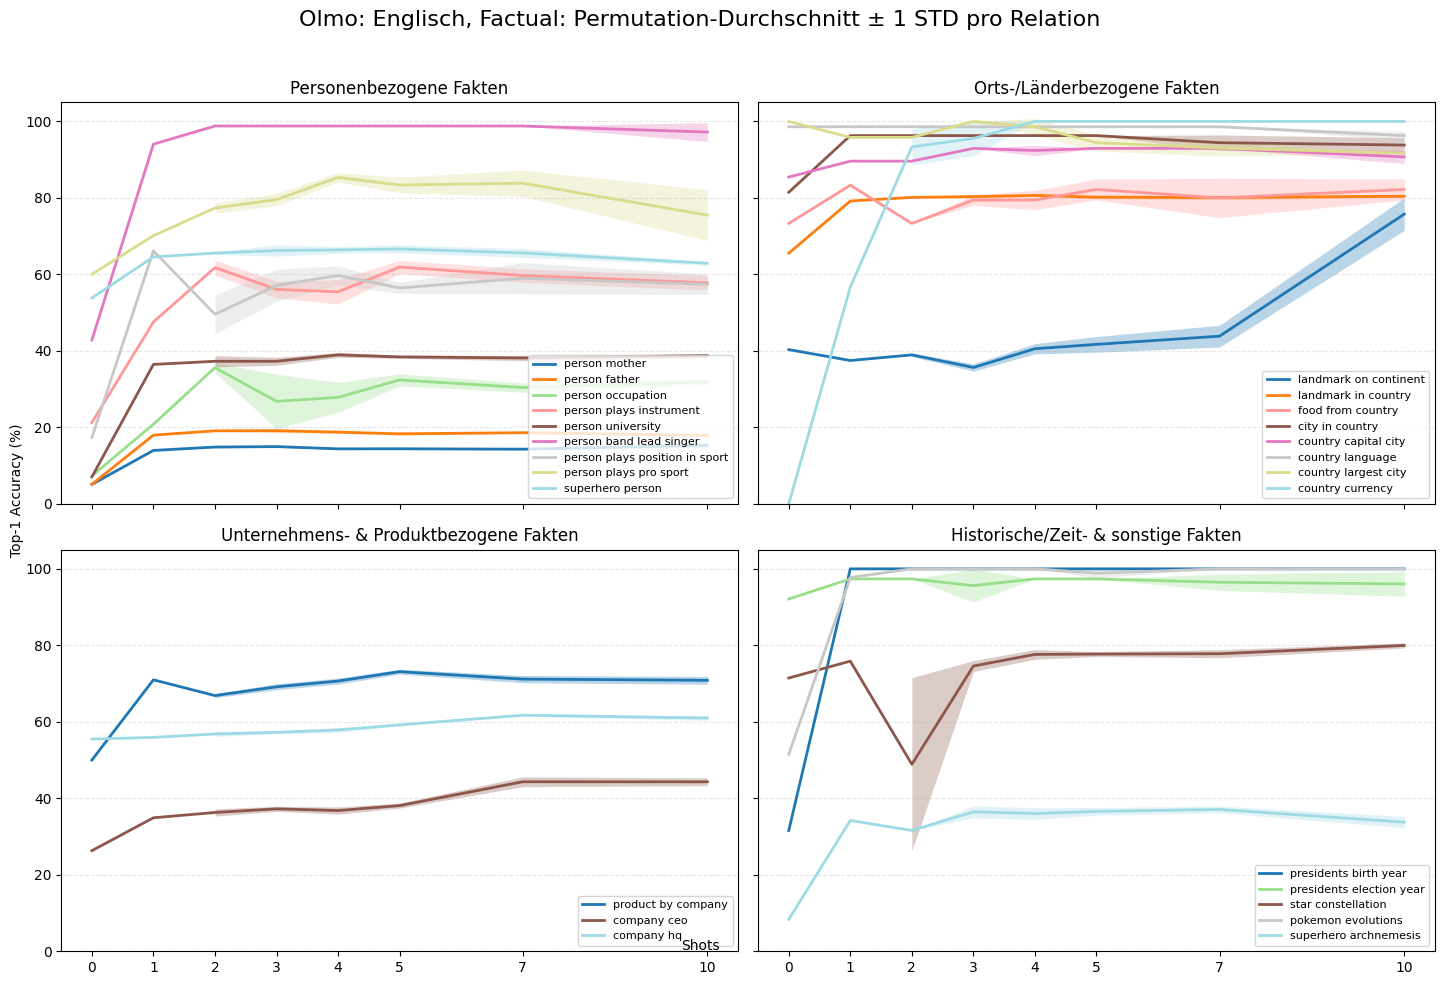

In [33]:
#top perm_1
base_dirs = {
    "few_shots_relationen": "/content/drive/MyDrive/master_thesis/data/factual_data/few_shots_final/result_10_accuracy/eval_accuracy_ollmo/permutation_0",
    "few_shots_permutation_1": "/content/drive/MyDrive/master_thesis/data/factual_data/few_shots_final/result_10_accuracy/eval_accuracy_ollmo/permutation_1",
    "few_shots_permutation_2": "/content/drive/MyDrive/master_thesis/data/factual_data/few_shots_final/result_10_accuracy/eval_accuracy_ollmo/permutation_2",
    "few_shots_permutation_3": "/content/drive/MyDrive/master_thesis/data/factual_data/few_shots_final/result_10_accuracy/eval_accuracy_ollmo/permutation_3",
    "few_shots_permutation_4": "/content/drive/MyDrive/master_thesis/data/factual_data/few_shots_final/result_10_accuracy/eval_accuracy_ollmo/permutation_4",
    "few_shots_permutation_5": "/content/drive/MyDrive/master_thesis/data/factual_data/few_shots_final/result_10_accuracy/eval_accuracy_ollmo/permutation_5"

}

plot_factual_accuracy(
    base_dirs,
    title="Olmo: Englisch, Factual: Permutation-Durchschnitt ± 1 STD pro Relation",
    save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy",
    fname="olmo_english_factual_top1"
)


/tmp/ipython-input-32-3355171943.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))


[INFO] Relation 'country university' nicht in Daten gefunden – übersprungen.


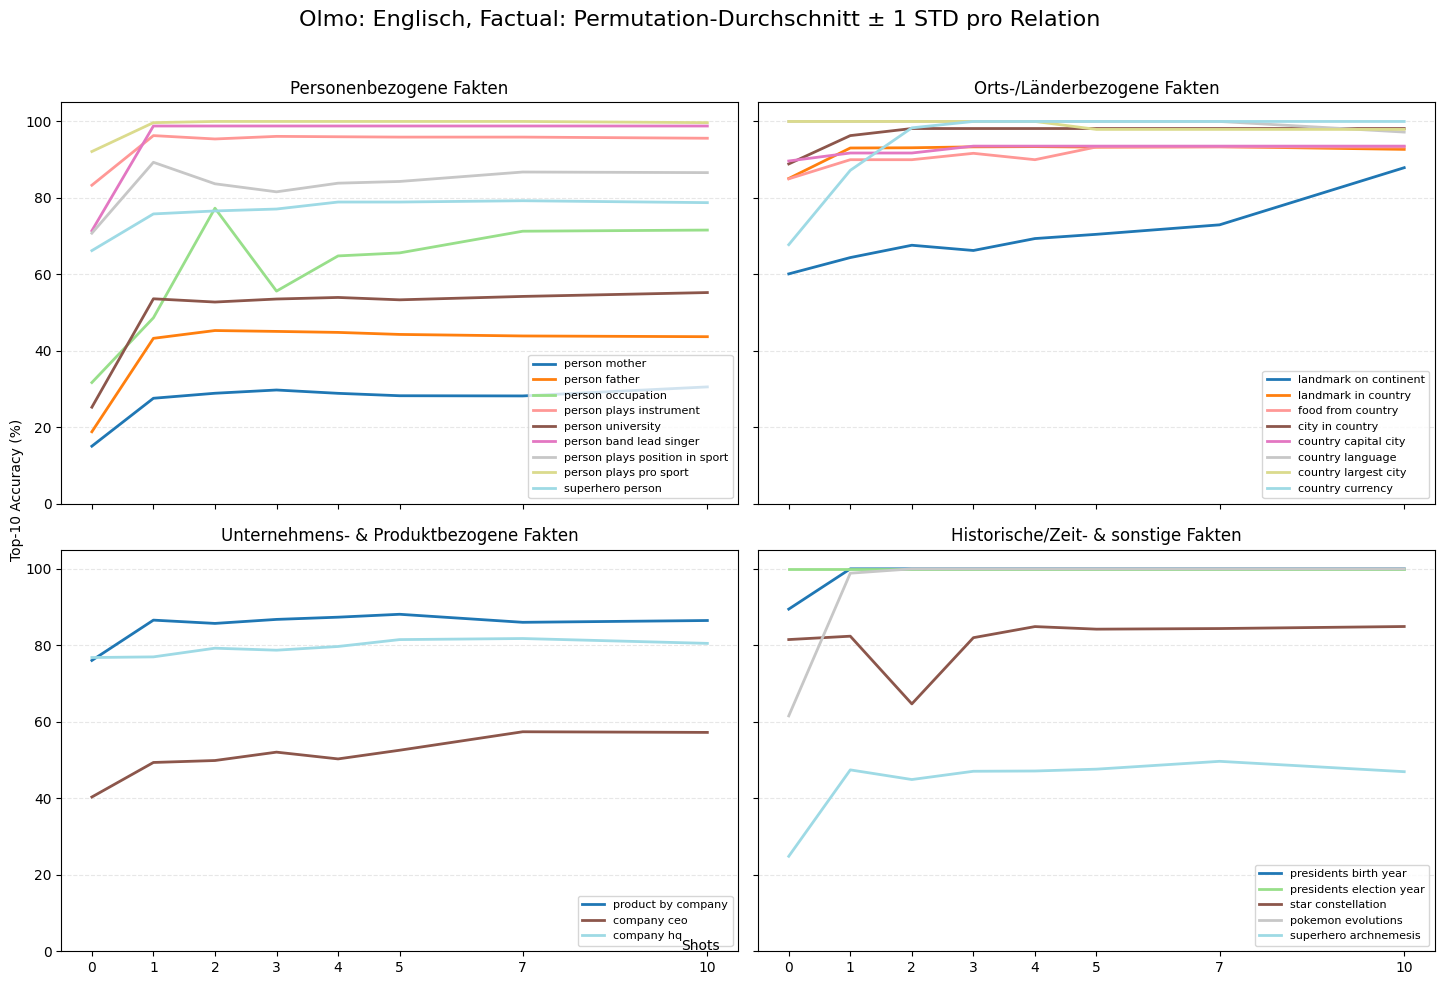

In [34]:
#top perm_10
base_dirs = {
    "few_shots_relationen": "/content/drive/MyDrive/master_thesis/data/factual_data/few_shots_final/result_10_accuracy/eval_accuracy_ollmo/permutation_0"

}

plot_factual_accuracy_10(
    base_dirs,
    title="Olmo: Englisch, Factual: Permutation-Durchschnitt ± 1 STD pro Relation",
    save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy",
    fname="olmo_english_factual_top10"
)


###LLaMA

/tmp/ipython-input-31-3479637626.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))


[INFO] Relation 'country university' nicht in Daten gefunden – übersprungen.


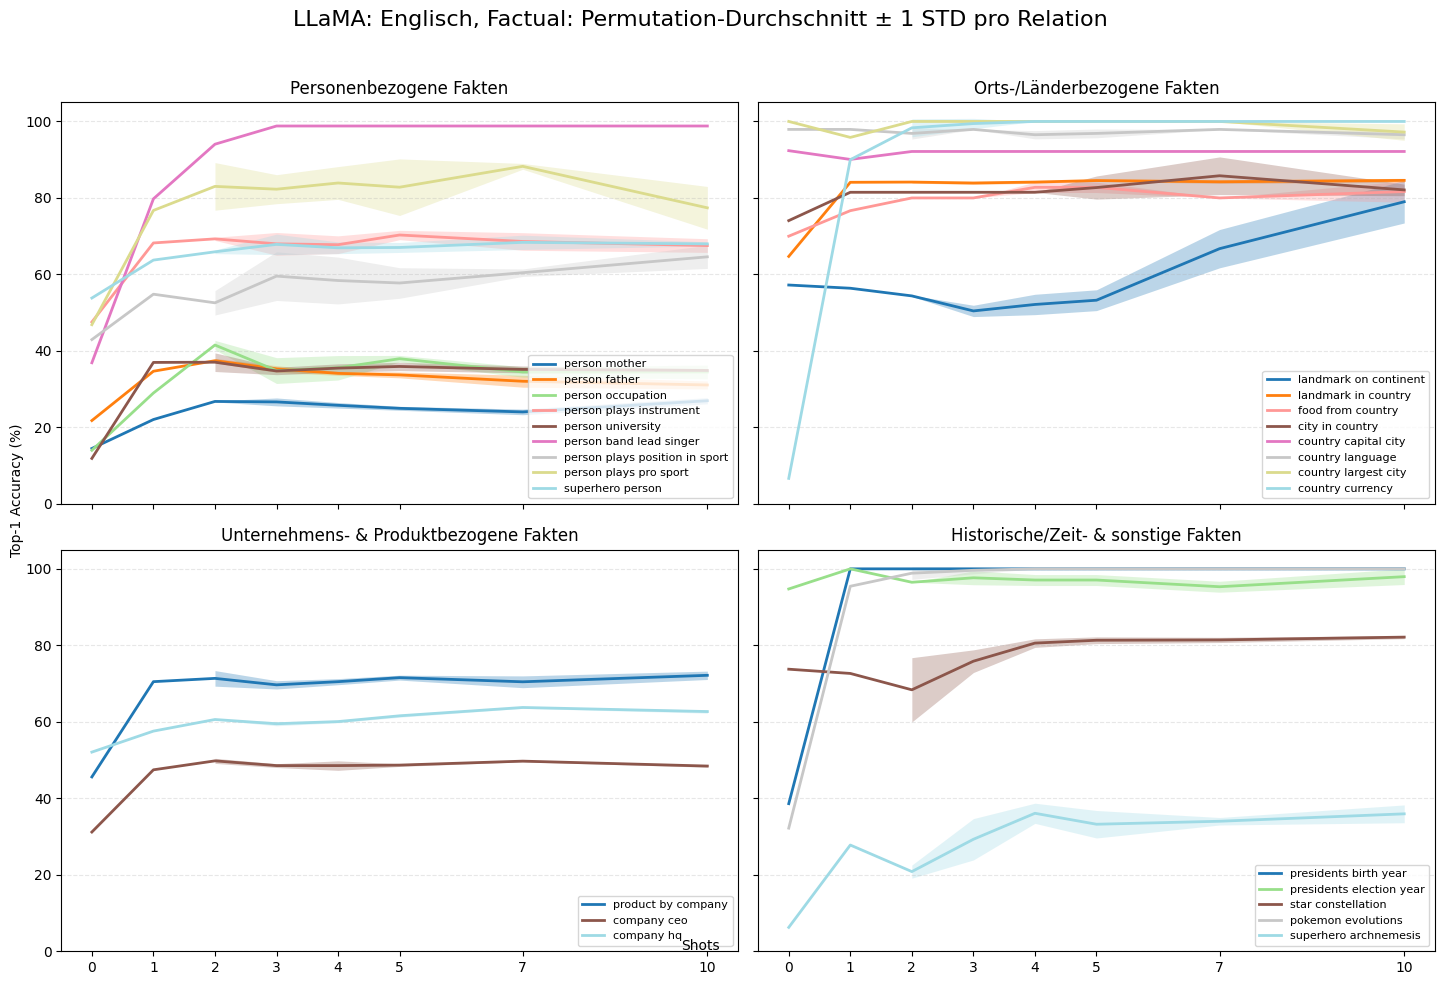

In [35]:
#top 1
base_dirs = {
    "few_shots_relationen": "/content/drive/MyDrive/master_thesis/data/factual_data/few_shots_final/result_10_accuracy/eval_accuracy/permutation_0",
    "few_shots_permutation_1": "/content/drive/MyDrive/master_thesis/data/factual_data/few_shots_final/result_10_accuracy/eval_accuracy/permutation_1",
    "few_shots_permutation_2": "/content/drive/MyDrive/master_thesis/data/factual_data/few_shots_final/result_10_accuracy/eval_accuracy/permutation_2",
    "few_shots_permutation_3": "/content/drive/MyDrive/master_thesis/data/factual_data/few_shots_final/result_10_accuracy/eval_accuracy/permutation_3",
    "few_shots_permutation_4": "/content/drive/MyDrive/master_thesis/data/factual_data/few_shots_final/result_10_accuracy/eval_accuracy/permutation_4",
    "few_shots_permutation_5": "/content/drive/MyDrive/master_thesis/data/factual_data/few_shots_final/result_10_accuracy/eval_accuracy/permutation_5"
}

plot_factual_accuracy(
    base_dirs,
    title="LLaMA: Englisch, Factual: Permutation-Durchschnitt ± 1 STD pro Relation",
    save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy",
    fname="llama_english_factual_top1"
)


/tmp/ipython-input-32-3355171943.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))


[INFO] Relation 'country university' nicht in Daten gefunden – übersprungen.


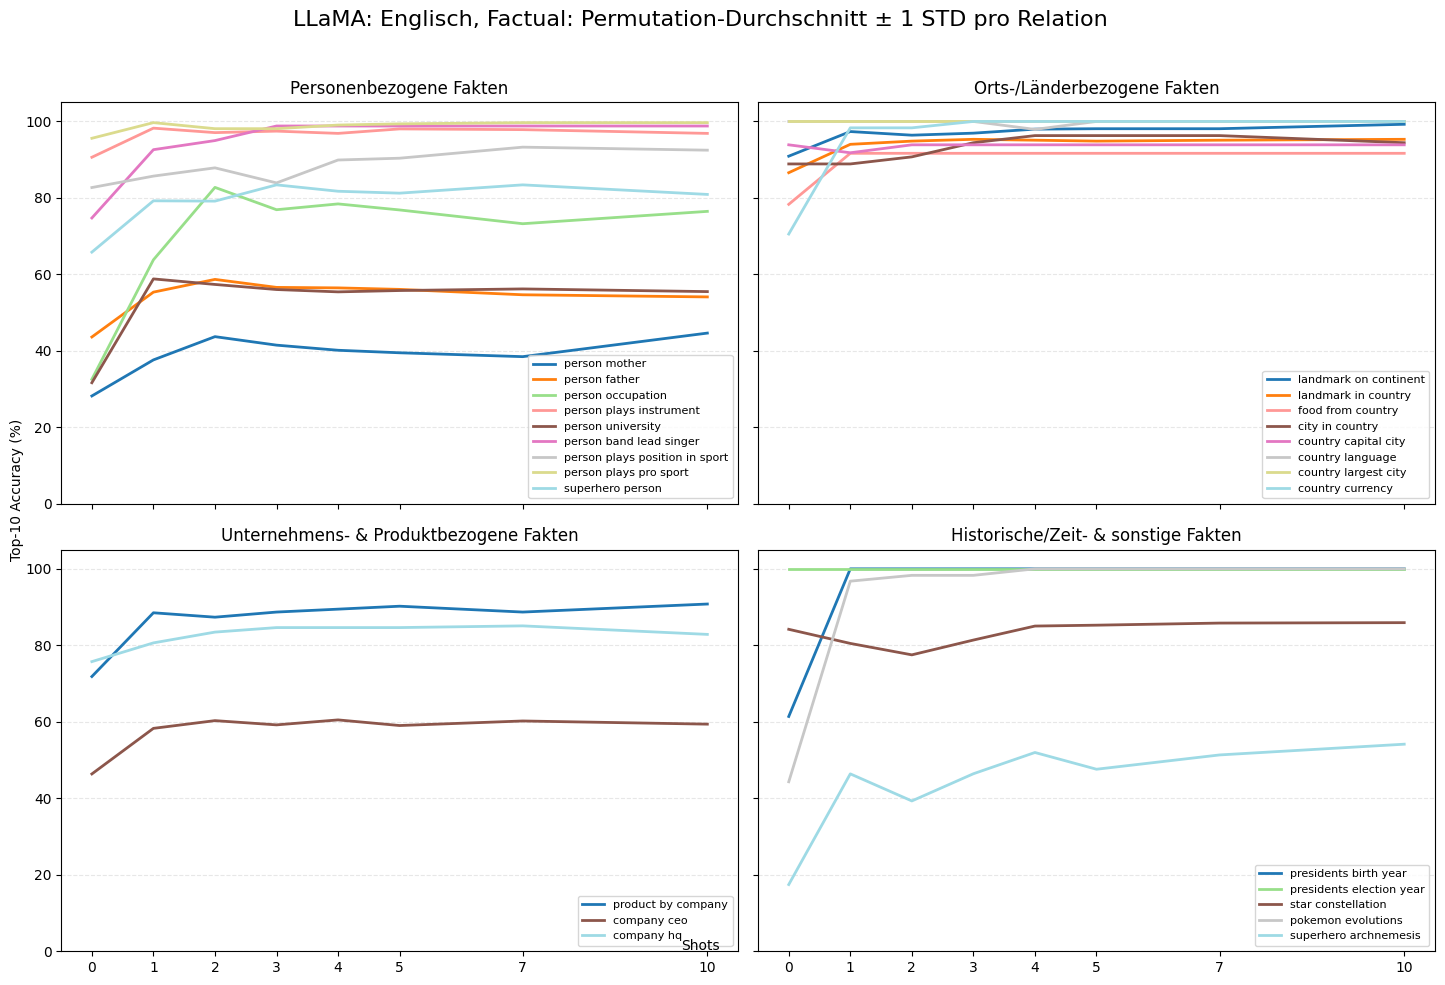

In [36]:
#top 10
base_dirs = {
    "few_shots_relationen": "/content/drive/MyDrive/master_thesis/data/factual_data/few_shots_final/result_10_accuracy/eval_accuracy/permutation_0",

}

plot_factual_accuracy_10(
    base_dirs,
    title="LLaMA: Englisch, Factual: Permutation-Durchschnitt ± 1 STD pro Relation",
    save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy",
    fname="llama_english_factual_top10"
)

##DE

/tmp/ipython-input-31-3479637626.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))


[INFO] Relation 'country university' nicht in Daten gefunden – übersprungen.


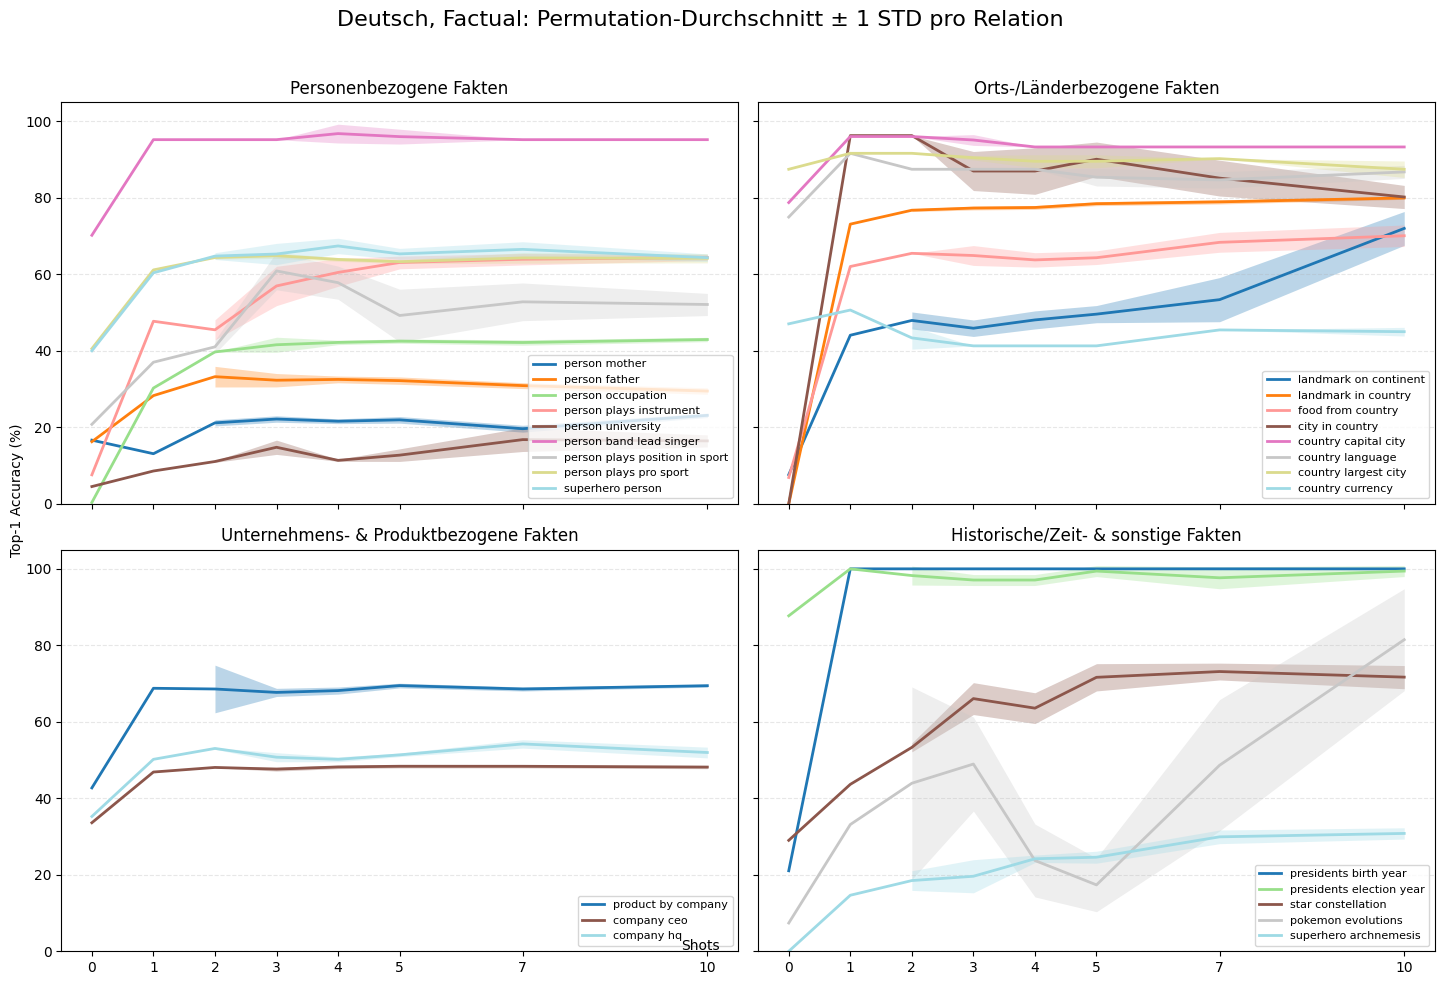

In [37]:
#top1
base_dirs = {
    "few_shots_relationen": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/de/result_10_accuracy/eval_accuracy/permutation_0",
    "few_shots_permutation_1": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/de/result_10_accuracy/eval_accuracy/permutation_1",
    "few_shots_permutation_2": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/de/result_10_accuracy/eval_accuracy/permutation_2",
    "few_shots_permutation_3": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/de/result_10_accuracy/eval_accuracy/permutation_3",
    "few_shots_permutation_4": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/de/result_10_accuracy/eval_accuracy/permutation_4",
    "few_shots_permutation_5": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/de/result_10_accuracy/eval_accuracy/permutation_5"
}
plot_factual_accuracy(
    base_dirs,
    title="Deutsch, Factual: Permutation-Durchschnitt ± 1 STD pro Relation",
    save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy",
    fname="llama_deutsch_factual_top1"
)

/tmp/ipython-input-32-3355171943.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))


[INFO] Relation 'country university' nicht in Daten gefunden – übersprungen.


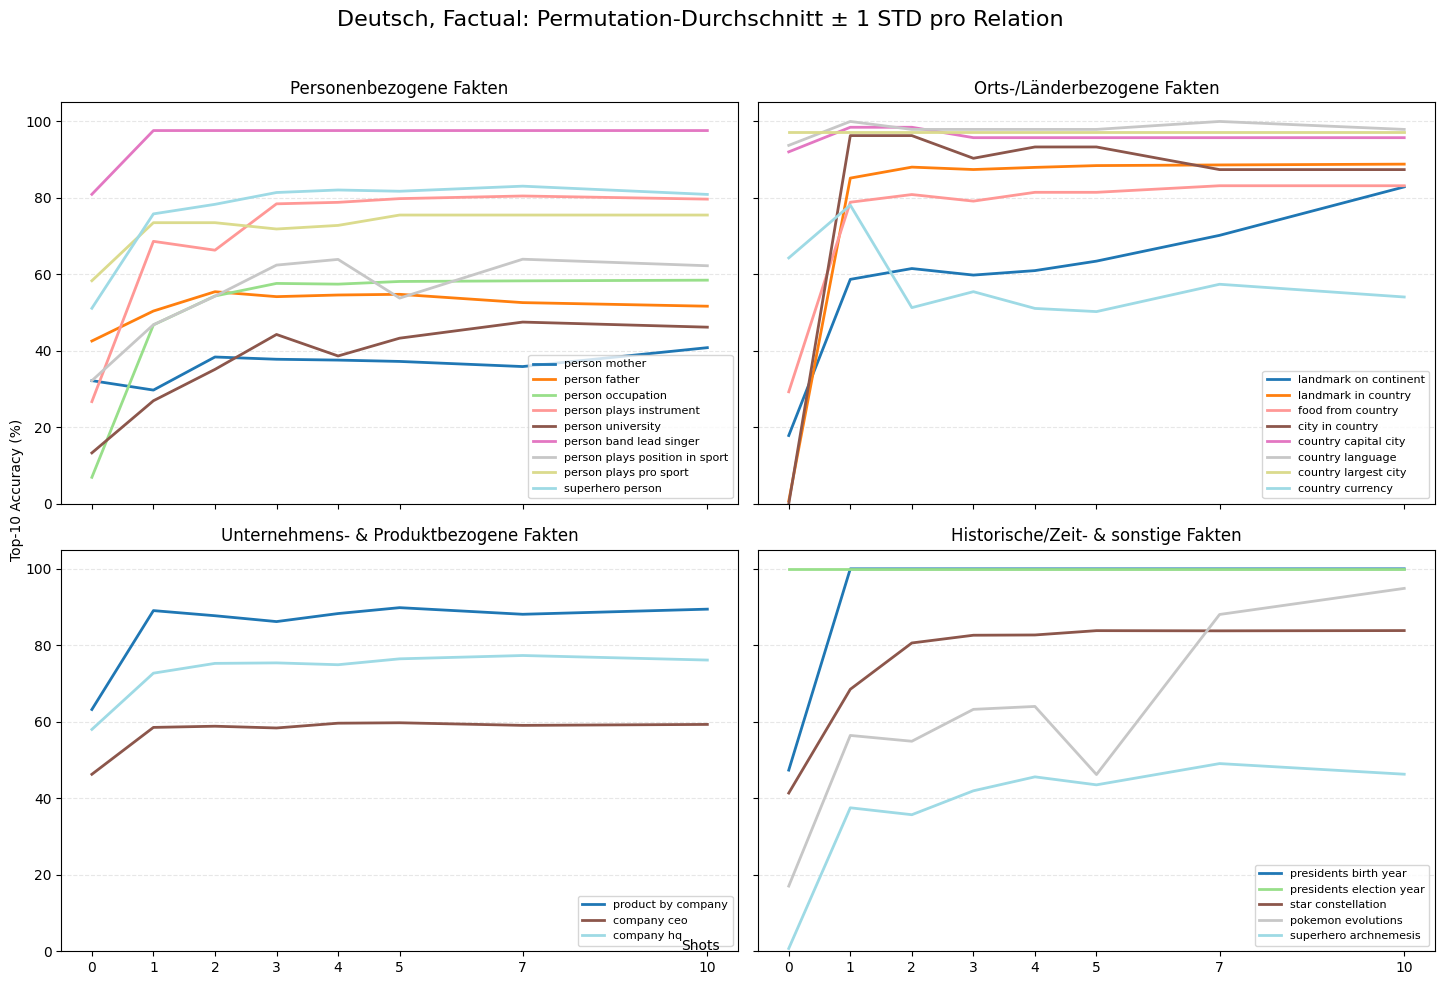

In [38]:
#top10
base_dirs = {
    "few_shots_relationen": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/de/result_10_accuracy/eval_accuracy/permutation_0"

}
plot_factual_accuracy_10(
    base_dirs,
    title="Deutsch, Factual: Permutation-Durchschnitt ± 1 STD pro Relation",
    save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy",
    fname="llama_deutsch_factual_top_10"
)

##ES

/tmp/ipython-input-31-3479637626.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))


[INFO] Relation 'country university' nicht in Daten gefunden – übersprungen.


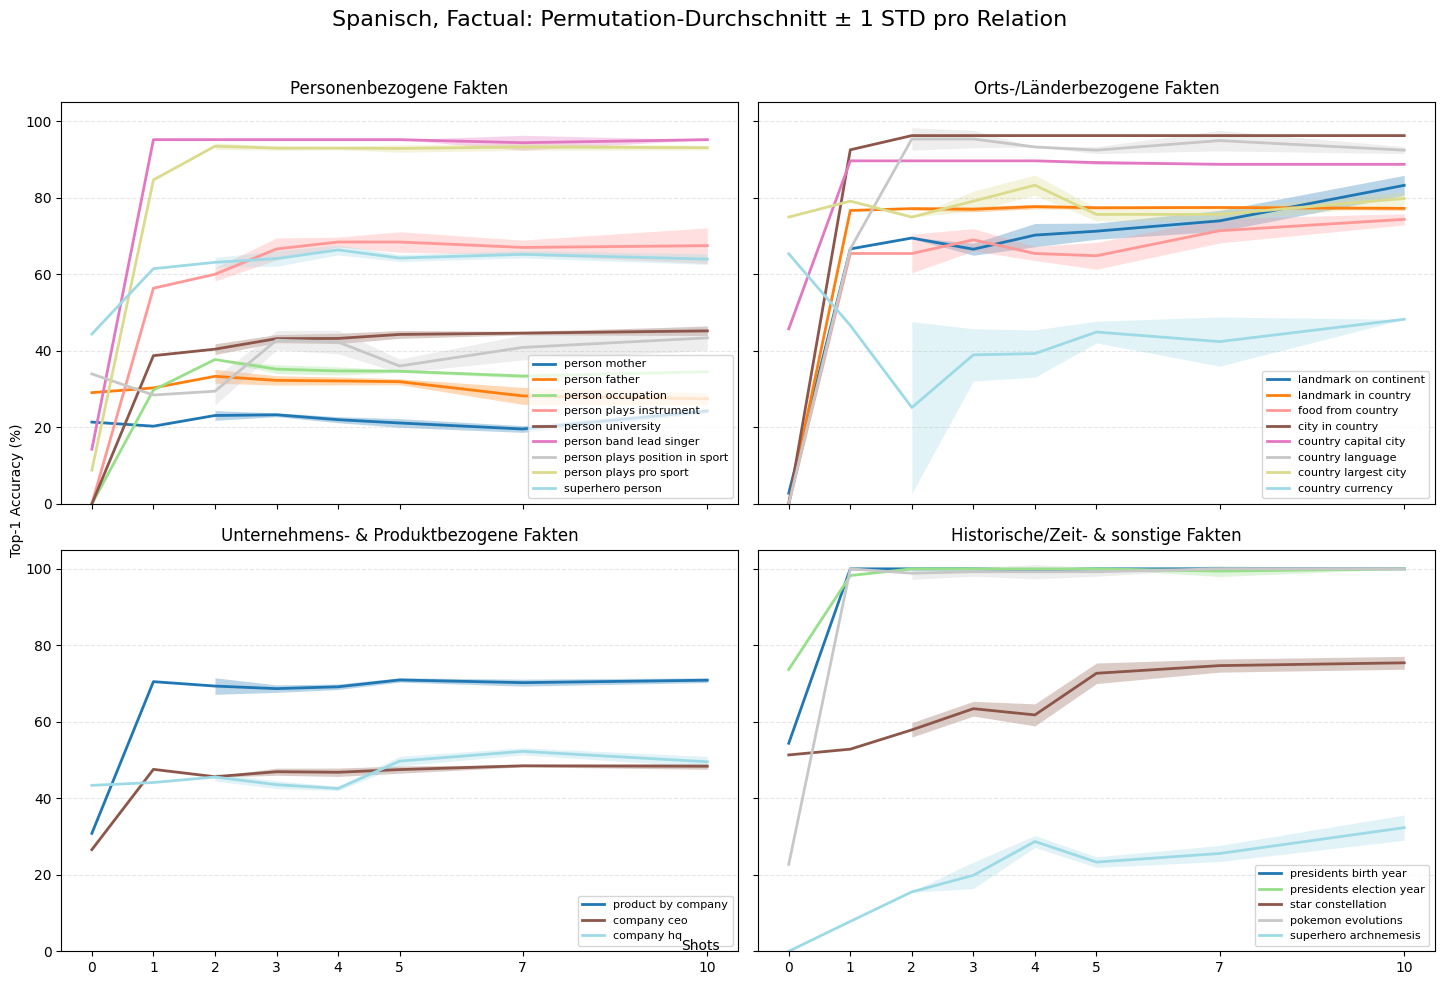

In [39]:
#top 1
base_dirs = {
    "few_shots_relationen": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/es/result_10_accuracy/eval_accuracy/permutation_0",
    "few_shots_permutation_1": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/es/result_10_accuracy/eval_accuracy/permutation_1",
    "few_shots_permutation_2": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/es/result_10_accuracy/eval_accuracy/permutation_2",
    "few_shots_permutation_3": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/es/result_10_accuracy/eval_accuracy/permutation_3",
    "few_shots_permutation_4": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/es/result_10_accuracy/eval_accuracy/permutation_4",
    "few_shots_permutation_5": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/es/result_10_accuracy/eval_accuracy/permutation_5"
}

plot_factual_accuracy(
    base_dirs,
    title="Spanisch, Factual: Permutation-Durchschnitt ± 1 STD pro Relation",
    save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy",
    fname="llama_es_factual_top1"
)


/tmp/ipython-input-32-3355171943.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))


[INFO] Relation 'country university' nicht in Daten gefunden – übersprungen.


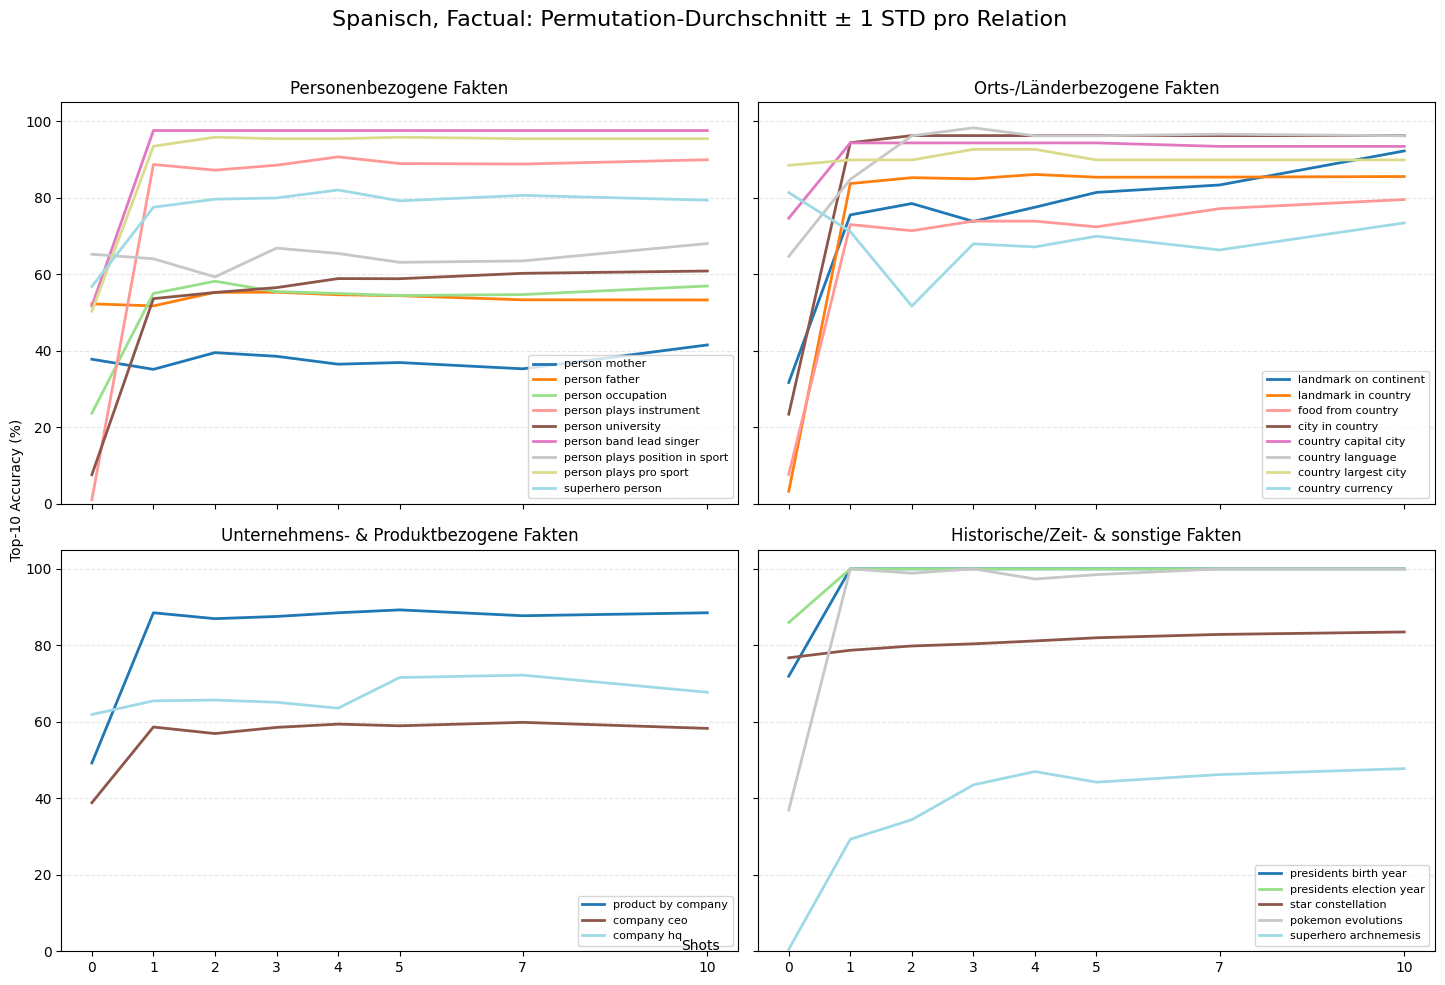

In [40]:

#top 10

base_dirs = {
    "few_shots_relationen": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/es/result_10_accuracy/eval_accuracy/permutation_0"
}

plot_factual_accuracy_10(
    base_dirs,
    title="Spanisch, Factual: Permutation-Durchschnitt ± 1 STD pro Relation",
    save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy",
    fname="llama_es_factual_top10"
)


##FR

/tmp/ipython-input-31-3479637626.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))


[INFO] Relation 'country university' nicht in Daten gefunden – übersprungen.


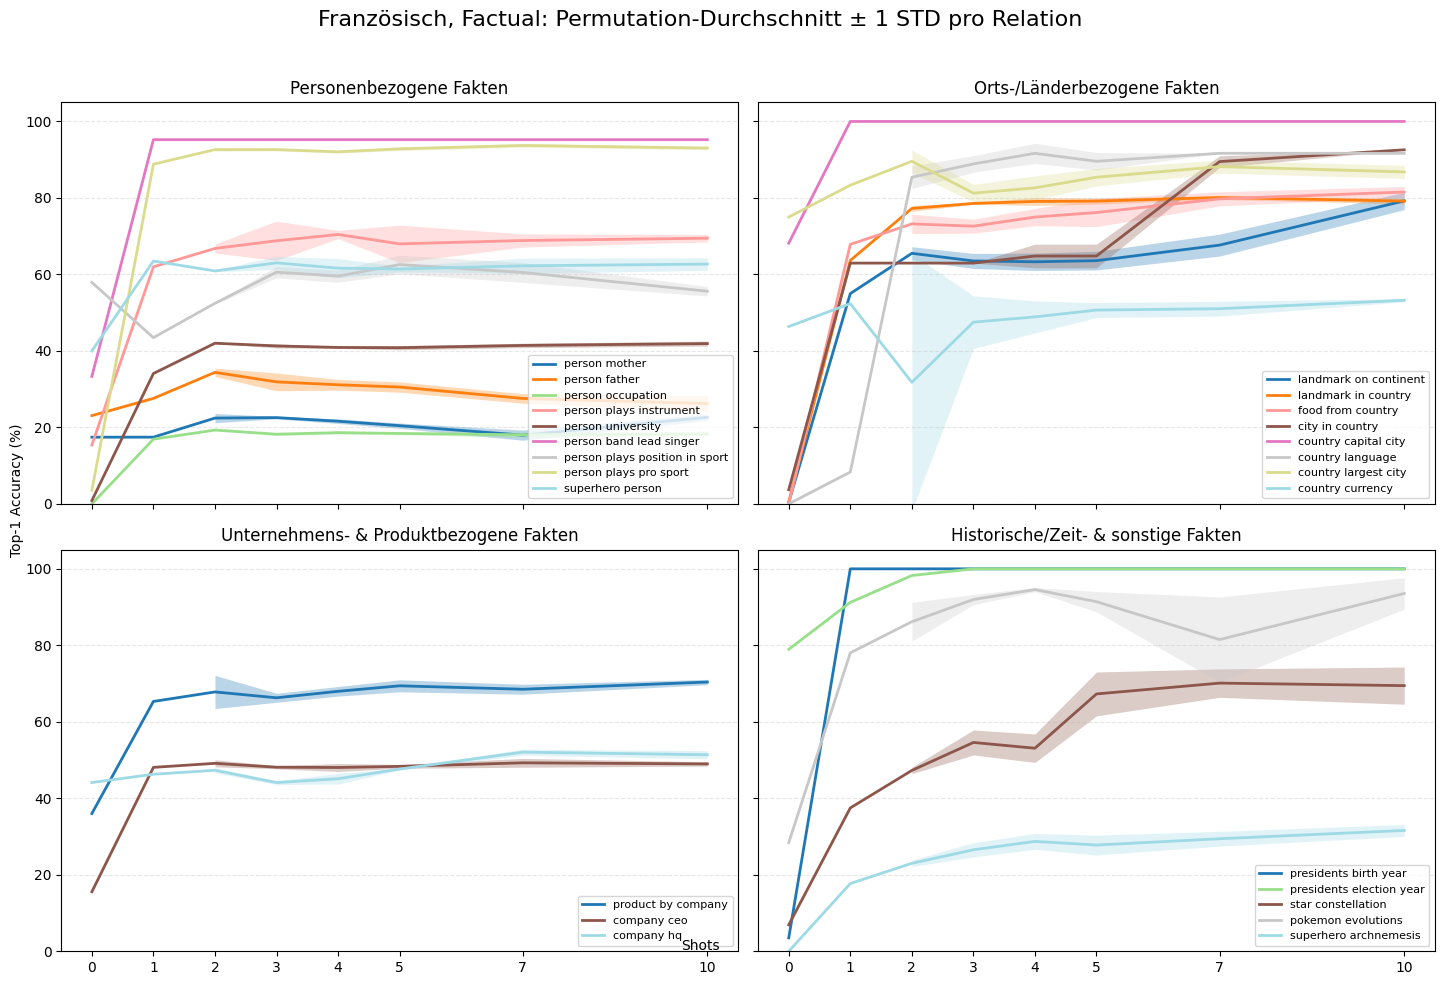

In [41]:
base_dirs = {
    "few_shots_relationen": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/fr/result_10_accuracy/eval_accuracy/permutation_0",
    "few_shots_permutation_1": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/fr/result_10_accuracy/eval_accuracy/permutation_1",
    "few_shots_permutation_2": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/fr/result_10_accuracy/eval_accuracy/permutation_2",
    "few_shots_permutation_3": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/fr/result_10_accuracy/eval_accuracy/permutation_3",
    "few_shots_permutation_4": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/fr/result_10_accuracy/eval_accuracy/permutation_4",
    "few_shots_permutation_5": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/fr/result_10_accuracy/eval_accuracy/permutation_5"
}

plot_factual_accuracy(
    base_dirs,
    title="Französisch, Factual: Permutation-Durchschnitt ± 1 STD pro Relation",
    save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy",
    fname="llama_fr_factual_top1"
)



/tmp/ipython-input-32-3355171943.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))


[INFO] Relation 'country university' nicht in Daten gefunden – übersprungen.


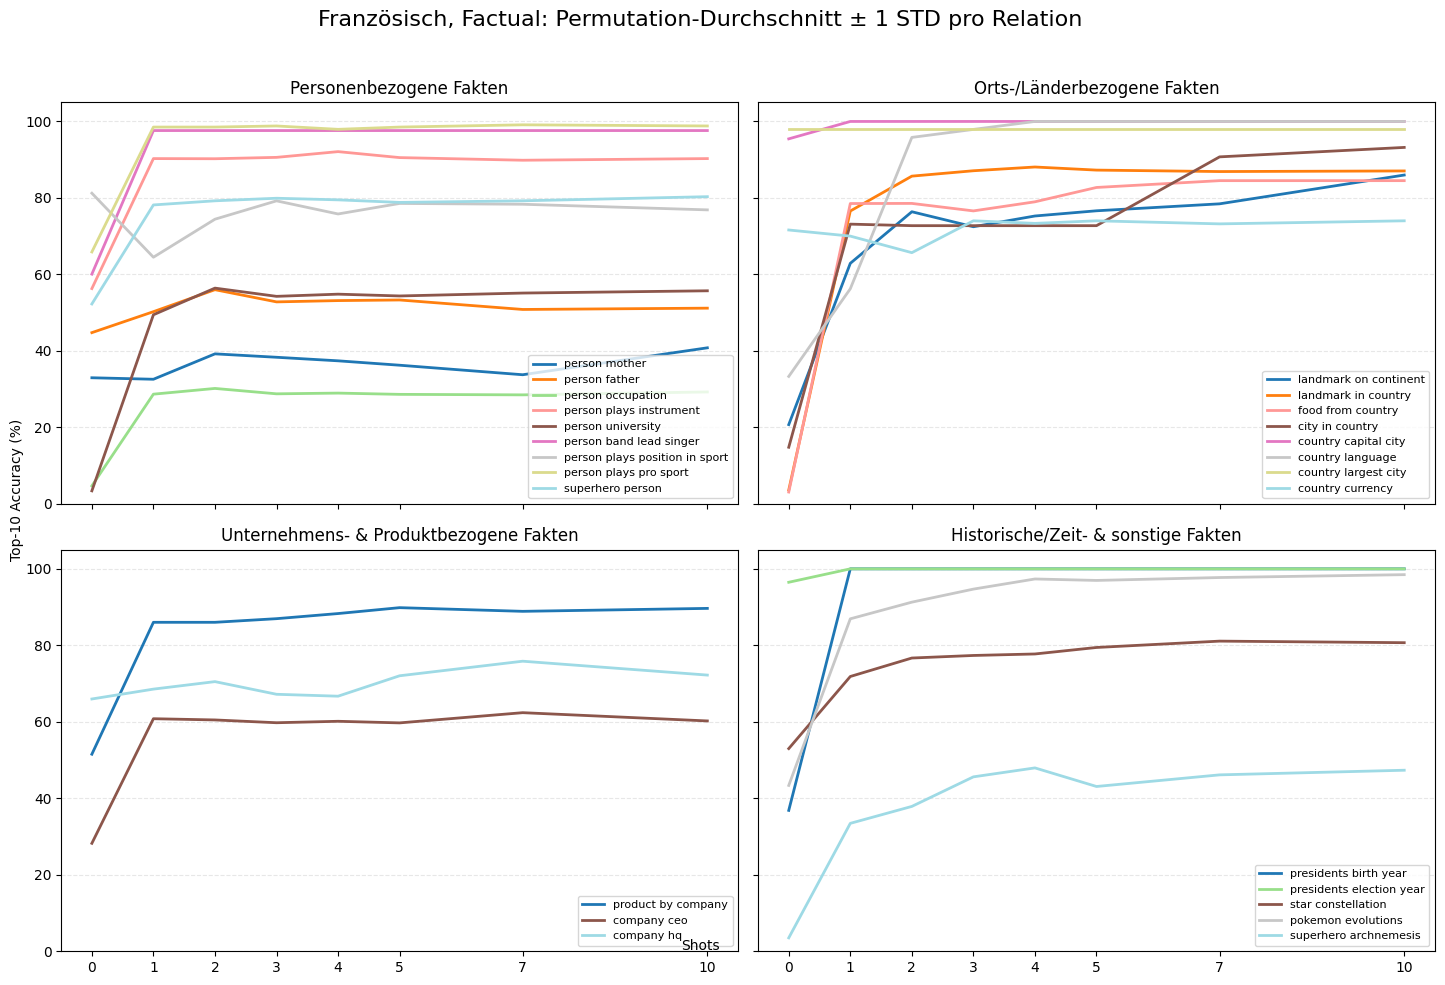

In [42]:
base_dirs = {
    "few_shots_relationen": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/fr/result_10_accuracy/eval_accuracy/permutation_0"
}

plot_factual_accuracy_10(
    base_dirs,
    title="Französisch, Factual: Permutation-Durchschnitt ± 1 STD pro Relation",
    save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy",
    fname="llama_fr_factual_top10"
)


##IT

/tmp/ipython-input-31-3479637626.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))


[INFO] Relation 'country university' nicht in Daten gefunden – übersprungen.


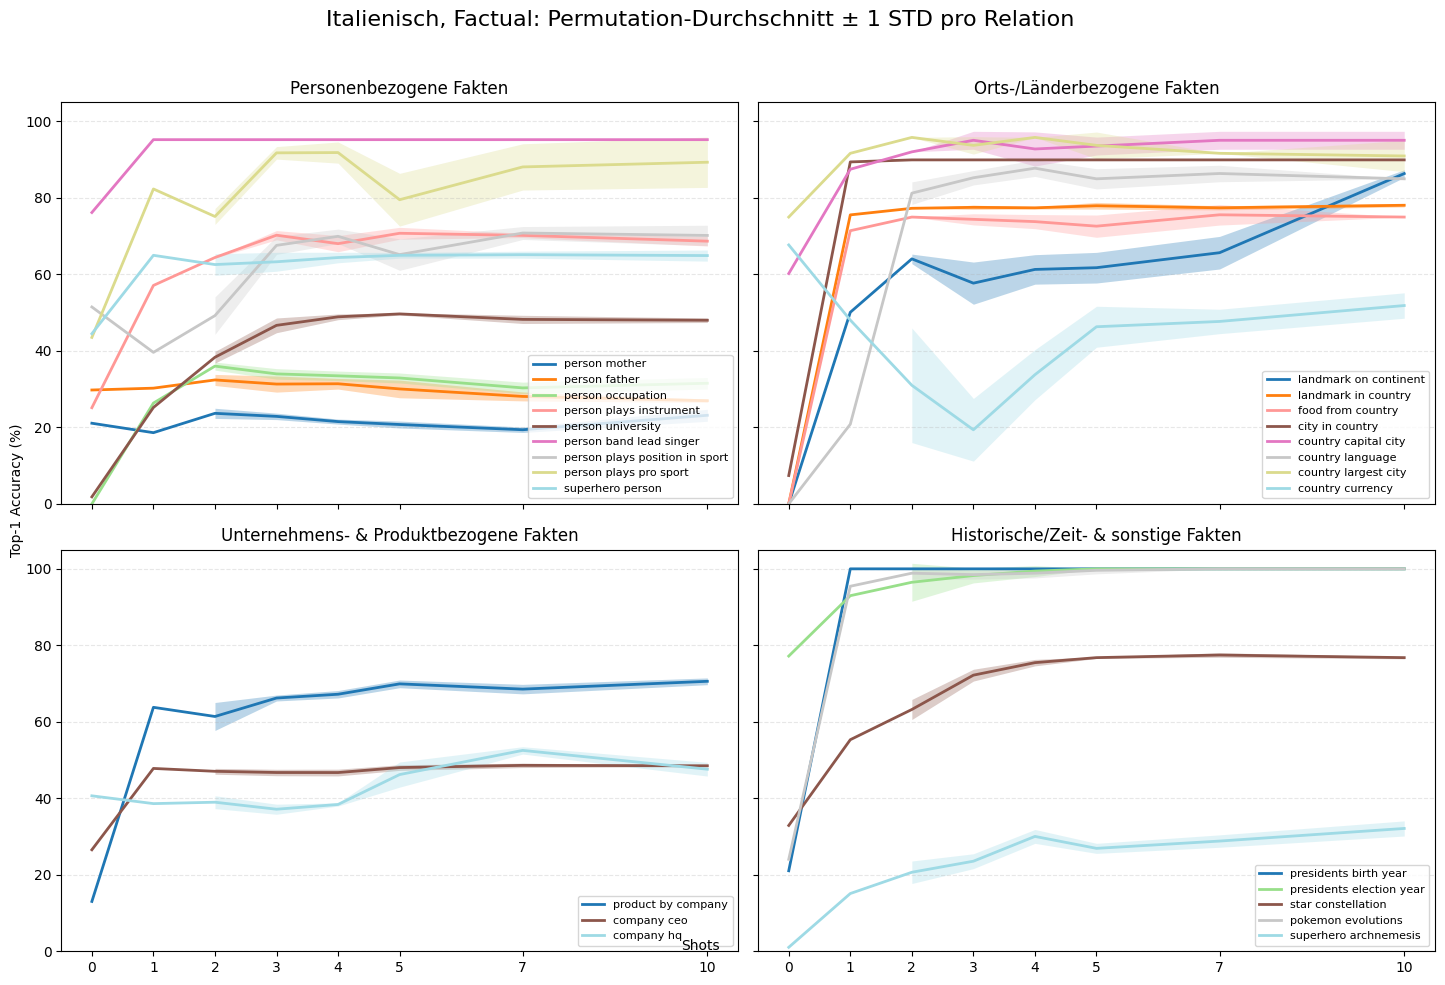

In [43]:
#top 1
base_dirs = {
    "few_shots_relationen": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/it/result_10_accuracy/eval_accuracy/permutation_0",
    "few_shots_permutation_1": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/it/result_10_accuracy/eval_accuracy/permutation_1",
    "few_shots_permutation_2": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/it/result_10_accuracy/eval_accuracy/permutation_2",
    "few_shots_permutation_3": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/it/result_10_accuracy/eval_accuracy/permutation_3",
    "few_shots_permutation_4": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/it/result_10_accuracy/eval_accuracy/permutation_4",
    "few_shots_permutation_5": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/it/result_10_accuracy/eval_accuracy/permutation_5"
}

plot_factual_accuracy(
    base_dirs,
    title="Italienisch, Factual: Permutation-Durchschnitt ± 1 STD pro Relation",
    save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy",
    fname="llama_it_factual_top1"
)


/tmp/ipython-input-32-3355171943.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))


[INFO] Relation 'country university' nicht in Daten gefunden – übersprungen.


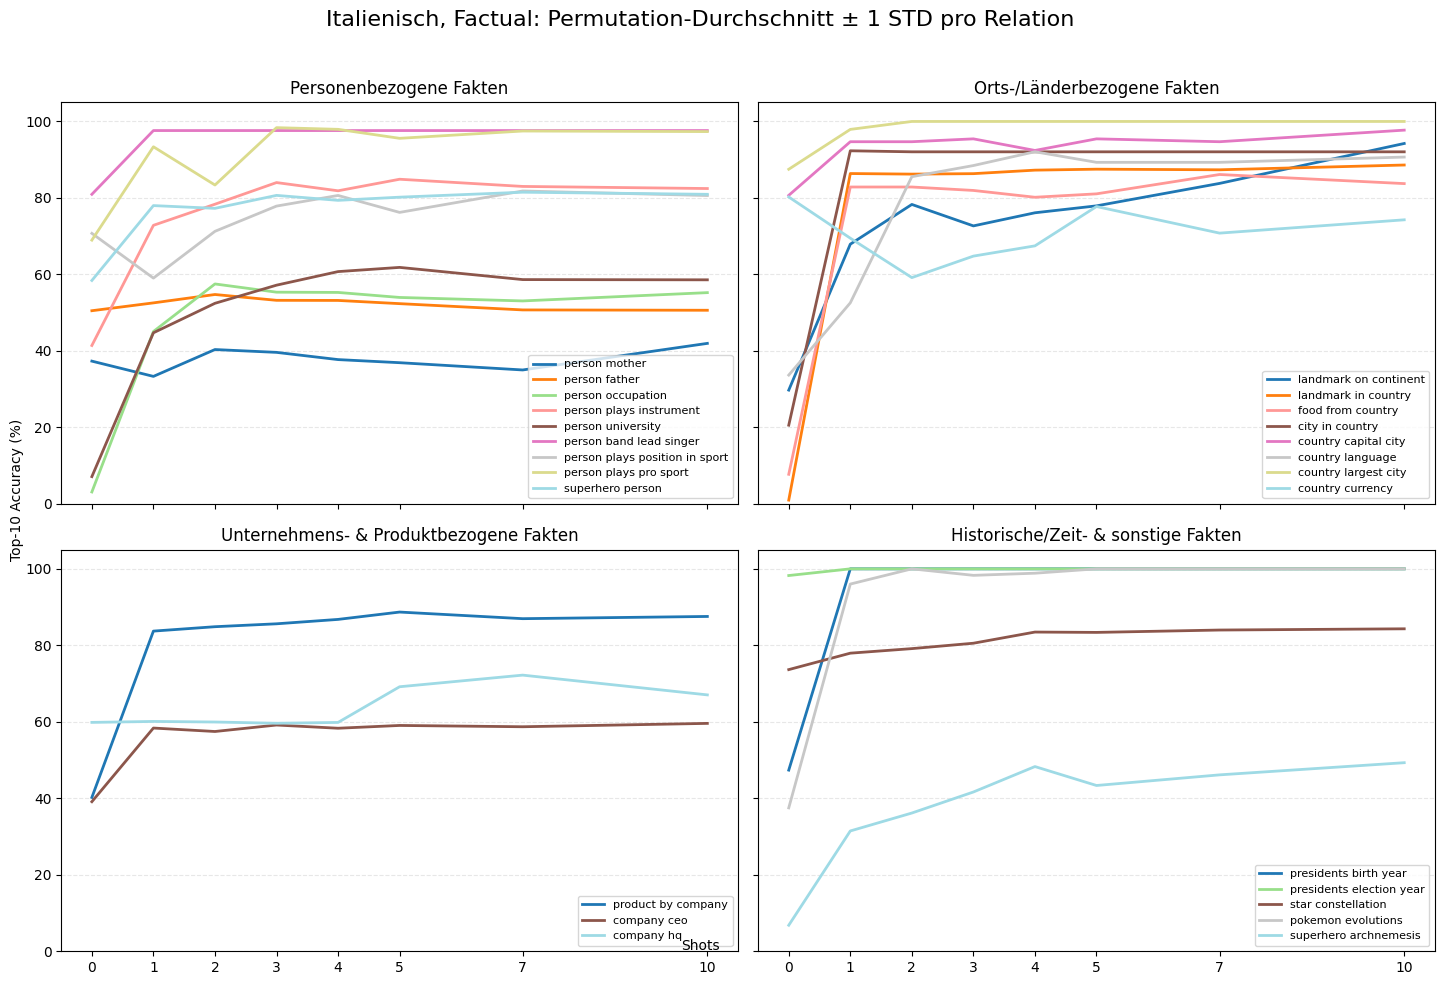

In [44]:
#top10
base_dirs = {
    "few_shots_relationen": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/it/result_10_accuracy/eval_accuracy/permutation_0"

}

plot_factual_accuracy_10(
    base_dirs,
    title="Italienisch, Factual: Permutation-Durchschnitt ± 1 STD pro Relation",
    save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy",
    fname="llama_it_factual_top10"
)


##PT

/tmp/ipython-input-31-3479637626.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))


[INFO] Relation 'country university' nicht in Daten gefunden – übersprungen.


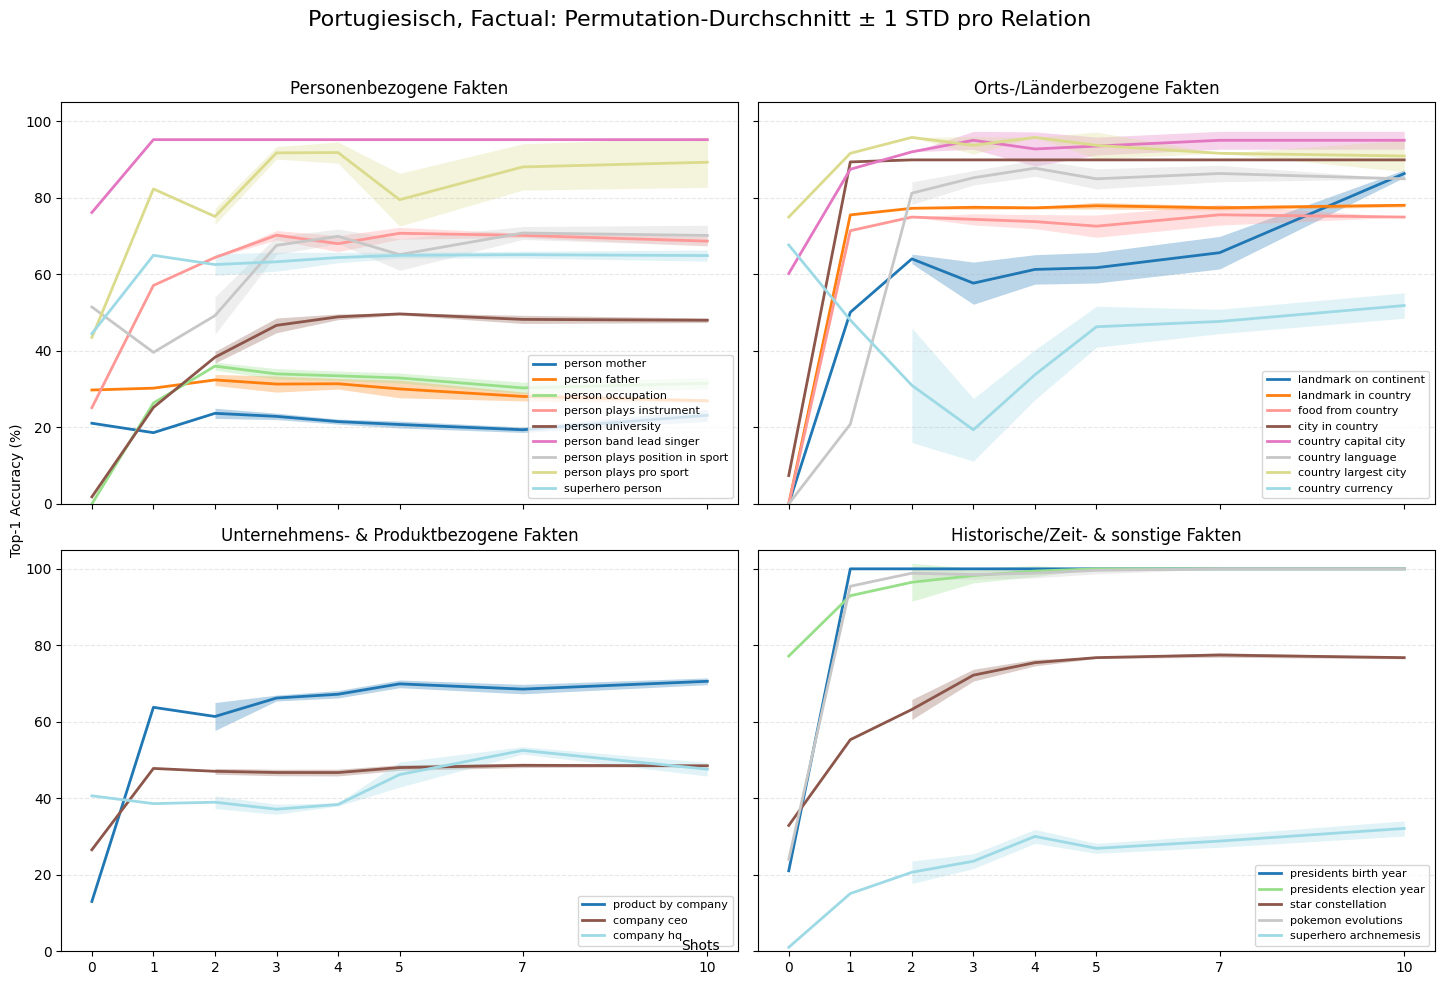

In [45]:
#top 1
base_dirs = {
    "few_shots_relationen": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/it/result_10_accuracy/eval_accuracy/permutation_0",
    "few_shots_permutation_1": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/it/result_10_accuracy/eval_accuracy/permutation_1",
    "few_shots_permutation_2": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/it/result_10_accuracy/eval_accuracy/permutation_2",
    "few_shots_permutation_3": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/it/result_10_accuracy/eval_accuracy/permutation_3",
    "few_shots_permutation_4": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/it/result_10_accuracy/eval_accuracy/permutation_4",
    "few_shots_permutation_5": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/it/result_10_accuracy/eval_accuracy/permutation_5"
}

plot_factual_accuracy(
    base_dirs,
    title="Portugiesisch, Factual: Permutation-Durchschnitt ± 1 STD pro Relation",
    save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy",
    fname="llama_pt_factual_top1"
)

/tmp/ipython-input-32-3355171943.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))


[INFO] Relation 'country university' nicht in Daten gefunden – übersprungen.


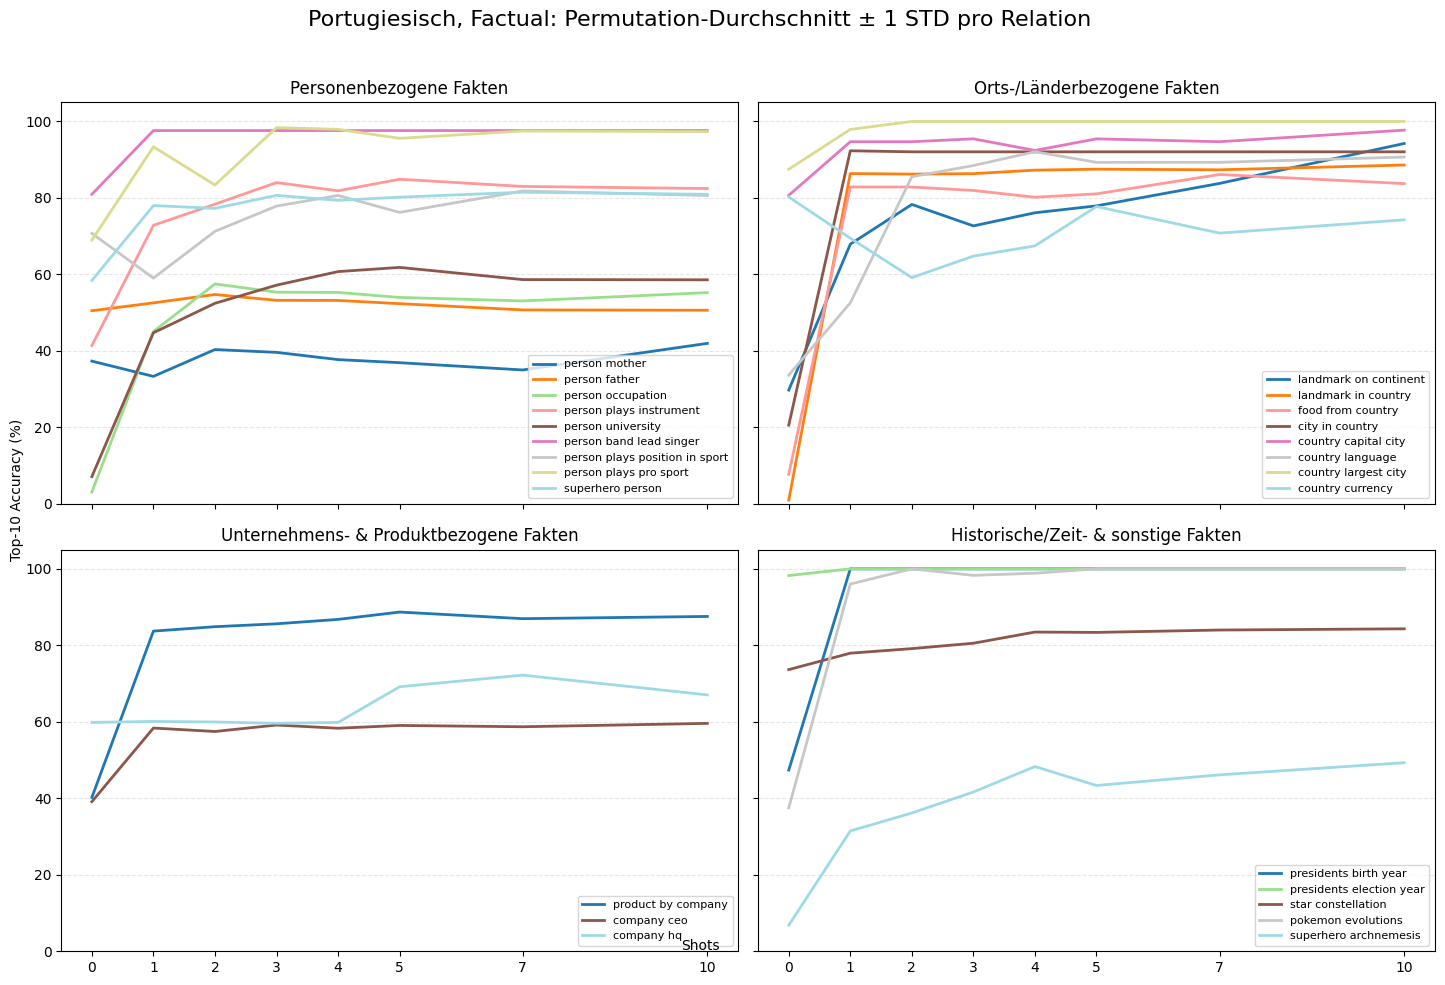

In [46]:
#top 10
base_dirs = {
    "few_shots_relationen": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/it/result_10_accuracy/eval_accuracy/permutation_0"
}

plot_factual_accuracy_10(
    base_dirs,
    title="Portugiesisch, Factual: Permutation-Durchschnitt ± 1 STD pro Relation",
    save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy",
    fname="llama_pt_factual_top10"
)

##HI


In [51]:
import os, re, json
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_factual_accuracy_hindi(
        base_dirs: dict,
        title: str = "Englisch, Factual: Permutation-Mittel ± 1 STD pro Relation",
        groups: dict[str, list[str]] | None = None,
        full_shots: list[int] | None = None,
        fname="subplot_accuracy",
        save_dir=None
    ):
    """
    Plottet Top-1-Accuracy (Mittel ± 1 STD) über verschiedene Shot-Zahlen,
    gruppiert nach semantischen Relationstypen (3 Subplots, eine Zeile).
    """

    if full_shots is None:
        full_shots = [0, 1, 2, 3, 4, 5, 7, 10]

    if groups is None:
        groups = OrderedDict({
            "Personenbezogene Fakten": [
                "person mother", "person father", "person occupation",
                "person plays instrument", "person university",
                "person lead singer of band",
                "person sport position", "plays pro sport",
                "superhero person"
            ],
            "Orts-/Länderbezogene Fakten": [
                "landmark on continent", "landmark in country",
                "country university", "food from country", "city in country",
                "country capital city", "country language",
                "country largest city", "country currency"
            ],
            "Historische/Zeit- & sonstige Fakten": [
                "president birth year", "president election year",
                "star constellation name", "pokemon evolution",
                "superhero archnemesis"
            ]
        })

    ALIASES = {
        "person lead singer of band": "person_band_lead_singer",
        "person sport position":      "person_plays_position_in_sport",
        "plays pro sport":            "person_plays_pro_sport",
        "pokemon evolution":          "pokemon_evolutions",
        "president birth year":       "presidents_birth_year",
        "president election year":    "presidents_election_year",
        "star constellation name":    "star_constellation",
        "country capital city":       "country_capital_city",
        "country largest city":       "country_largest_city",
        "country language":           "country_language"
    }

    records = []
    for root in base_dirs.values():
        for rel_folder in os.listdir(root):
            rel_path = os.path.join(root, rel_folder)
            if not os.path.isdir(rel_path):
                continue
            relation = rel_folder.replace("accuracy_", "")
            for fn in os.listdir(rel_path):
                if not fn.endswith(".json"):
                    continue
                if re.search(r"\b0shot\b", fn, re.IGNORECASE):
                    continue
                m = re.search(r"(\d+)shot", fn, re.IGNORECASE)
                if not m:
                    continue
                shot = int(m.group(1))
                with open(os.path.join(rel_path, fn), encoding="utf-8") as f:
                    data = json.load(f)
                acc = data.get("top_1_accuracy") or data.get("average_top_1_accuracy")
                if acc is None:
                    continue
                records.append(dict(Relation=relation, Shot=shot, Accuracy=float(acc)))

    df = pd.DataFrame(records)
    if df.empty:
        raise ValueError("Keine gültigen 1-Shot…10-Shot-Dateien gefunden")

    stats = (
        df.groupby(["Relation", "Shot"])["Accuracy"]
          .agg(mean="mean", std="std")
          .reset_index()
    )
    available = set(stats["Relation"].unique())

    def resolve(rel: str) -> str | None:
        if rel in available:
            return rel
        alt = rel.replace(" ", "_") if " " in rel else rel.replace("_", " ")
        if alt in available:
            return alt
        alt = ALIASES.get(rel)
        if alt in available:
            return alt
        return None

    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)
    axes = axes.flatten()

    for ax, (grp_title, rel_list) in zip(axes, groups.items()):
        cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))
        for idx_rel, rel in enumerate(rel_list):
            true_rel = resolve(rel)
            if true_rel is None:
                print(f"[INFO] Relation '{rel}' nicht gefunden – übersprungen.")
                continue

            sub = (stats[stats["Relation"] == true_rel]
                   .set_index("Shot")
                   .reindex(full_shots))
            mu, sig = sub["mean"], sub["std"]
            color = cmap_grp(idx_rel)

            ax.fill_between(full_shots, mu - sig, mu + sig,
                            color=color, alpha=0.3, linewidth=0, zorder=1)
            ax.plot(full_shots, mu, color=color, linewidth=2,
                    label=true_rel.replace("_", " "), zorder=2)

        ax.set_title(grp_title)
        ax.set_xticks(full_shots)
        ax.set_ylim(0, 105)
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)
        ax.legend(fontsize=8, loc='lower right')

    fig.text(0.5, 0.04, 'Shots', ha='center')
    fig.text(0.04, 0.5, 'Top-1 Accuracy (%)', va='center', rotation='vertical')
    fig.suptitle(title, fontsize=16)

    plt.tight_layout(rect=(0.04, 0, 1, 0.95))
    plt.show()

    if save_dir:
      os.makedirs(save_dir, exist_ok=True)
      fig.savefig(os.path.join(save_dir, f"{fname}.pdf"))
      fig.savefig(os.path.join(save_dir, f"{fname}.png"), dpi=300)


/tmp/ipython-input-51-97607594.py:108: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))


[INFO] Relation 'person mother' nicht gefunden – übersprungen.
[INFO] Relation 'person father' nicht gefunden – übersprungen.
[INFO] Relation 'person occupation' nicht gefunden – übersprungen.
[INFO] Relation 'person plays instrument' nicht gefunden – übersprungen.
[INFO] Relation 'person lead singer of band' nicht gefunden – übersprungen.
[INFO] Relation 'person sport position' nicht gefunden – übersprungen.
[INFO] Relation 'plays pro sport' nicht gefunden – übersprungen.
[INFO] Relation 'superhero person' nicht gefunden – übersprungen.
[INFO] Relation 'landmark in country' nicht gefunden – übersprungen.
[INFO] Relation 'country university' nicht gefunden – übersprungen.
[INFO] Relation 'star constellation name' nicht gefunden – übersprungen.
[INFO] Relation 'pokemon evolution' nicht gefunden – übersprungen.
[INFO] Relation 'superhero archnemesis' nicht gefunden – übersprungen.


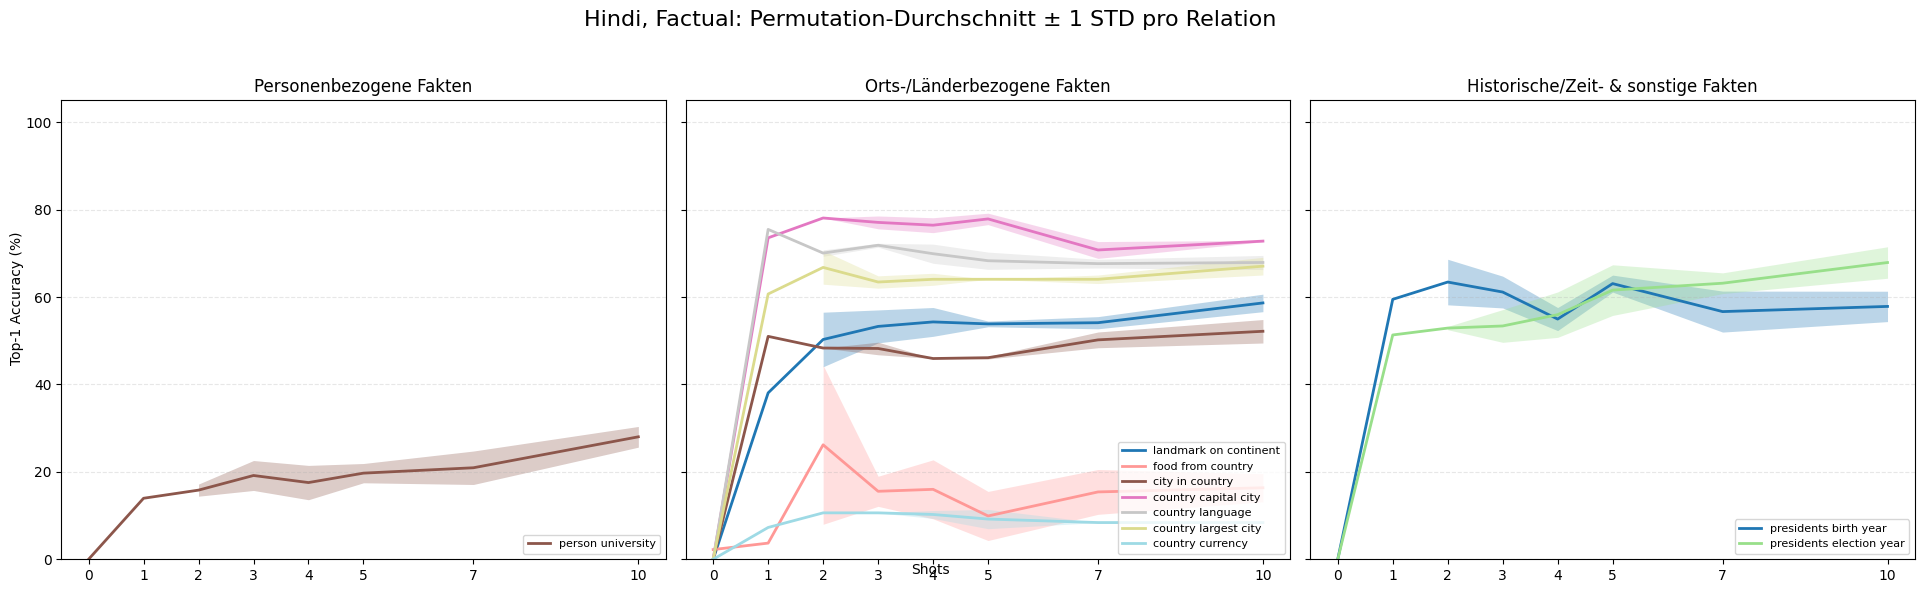

In [52]:
base_dirs = {
    "few_shots_relationen": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/hi/result_10_accuracy/eval_accuracy/permutation_0",
    "few_shots_permutation_1": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/hi/result_10_accuracy/eval_accuracy/permutation_1",
    "few_shots_permutation_2": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/hi/result_10_accuracy/eval_accuracy/permutation_2",
    "few_shots_permutation_3": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/hi/result_10_accuracy/eval_accuracy/permutation_3",
    "few_shots_permutation_4": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/hi/result_10_accuracy/eval_accuracy/permutation_4",
    "few_shots_permutation_5": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/hi/result_10_accuracy/eval_accuracy/permutation_5"
}

plot_factual_accuracy_hindi(
    base_dirs,
    title="Hindi, Factual: Permutation-Durchschnitt ± 1 STD pro Relation",
    save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy",
    fname="llama_hi_factual_top1"
)


/tmp/ipython-input-49-3665670313.py:108: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))


[INFO] Relation 'person mother' nicht gefunden – übersprungen.
[INFO] Relation 'person father' nicht gefunden – übersprungen.
[INFO] Relation 'person occupation' nicht gefunden – übersprungen.
[INFO] Relation 'person plays instrument' nicht gefunden – übersprungen.
[INFO] Relation 'person lead singer of band' nicht gefunden – übersprungen.
[INFO] Relation 'person sport position' nicht gefunden – übersprungen.
[INFO] Relation 'plays pro sport' nicht gefunden – übersprungen.
[INFO] Relation 'superhero person' nicht gefunden – übersprungen.
[INFO] Relation 'landmark in country' nicht gefunden – übersprungen.
[INFO] Relation 'country university' nicht gefunden – übersprungen.
[INFO] Relation 'star constellation name' nicht gefunden – übersprungen.
[INFO] Relation 'pokemon evolution' nicht gefunden – übersprungen.
[INFO] Relation 'superhero archnemesis' nicht gefunden – übersprungen.


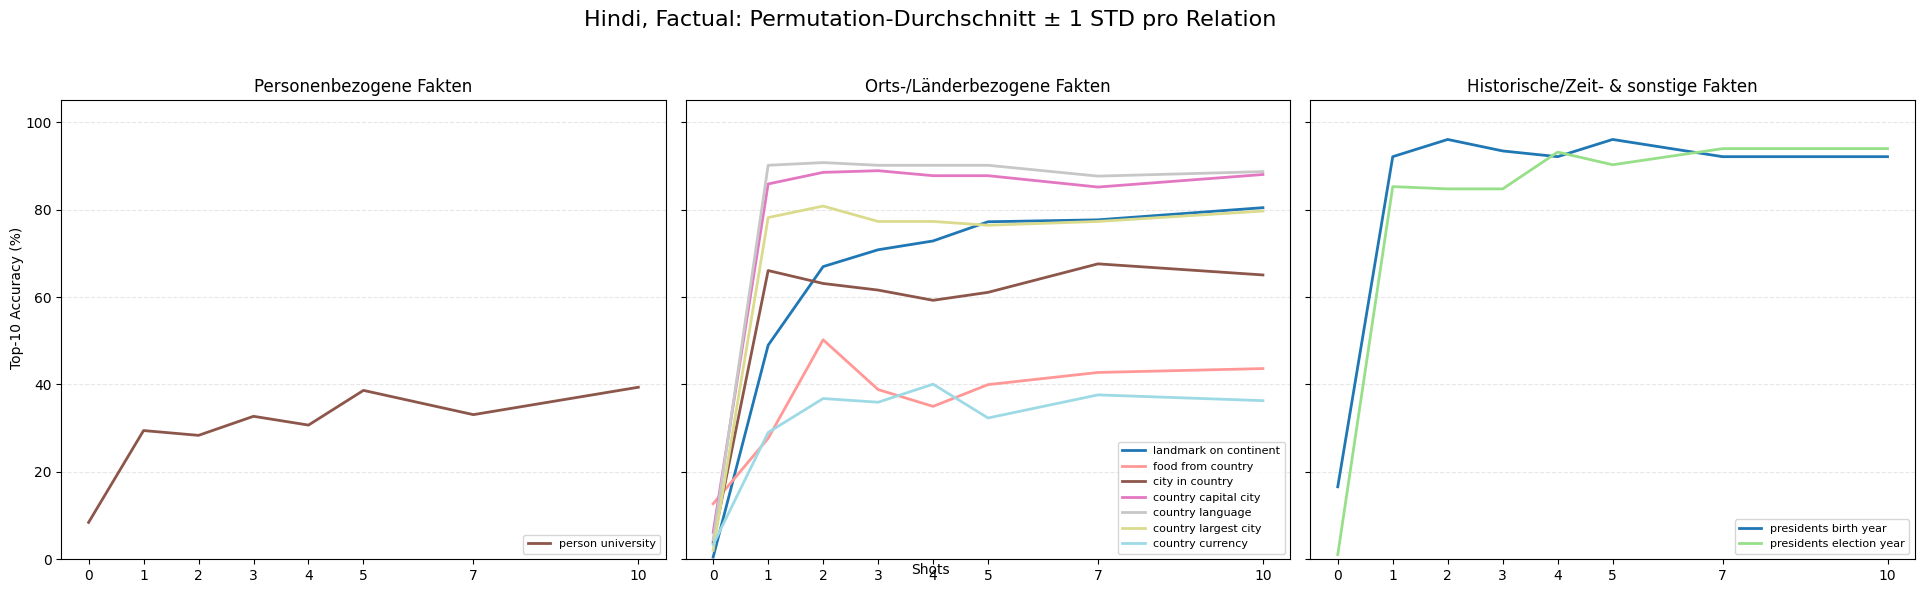

In [50]:
#top 10
base_dirs = {
    "few_shots_relationen": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/hi/result_10_accuracy/eval_accuracy/permutation_0"
}

plot_factual_accuracy_hindi_10(
    base_dirs,
    title="Hindi, Factual: Permutation-Durchschnitt ± 1 STD pro Relation",
    save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy",
    fname="llama_hi_factual_top10"
)


##TH

/tmp/ipython-input-31-3479637626.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))


[INFO] Relation 'person mother' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'person father' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'person occupation' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'person plays instrument' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'person sport position' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'superhero person' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'landmark in country' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'country university' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'company CEO' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'company hq' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'star constellation name' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'superhero archnemesis' nicht in Daten gefunden – übersprungen.


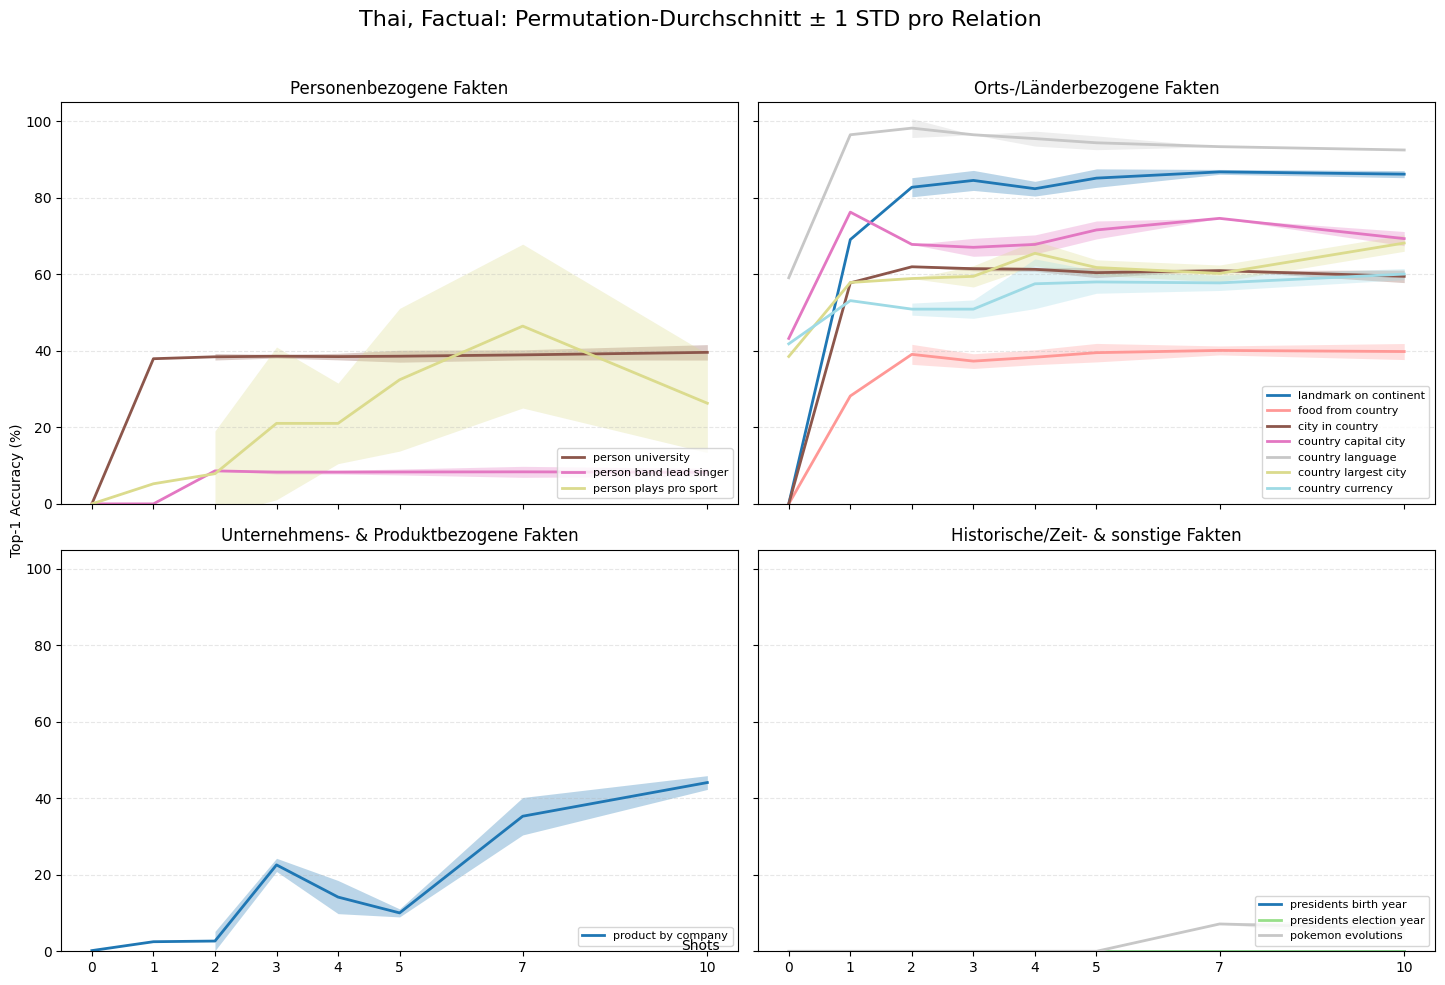

In [53]:
#top 1
base_dirs = {
    "few_shots_relationen": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/th/result_10_accuracy/eval_accuracy/permutation_0",
    "few_shots_permutation_1": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/th/result_10_accuracy/eval_accuracy/permutation_1",
    "few_shots_permutation_2": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/th/result_10_accuracy/eval_accuracy/permutation_2",
    "few_shots_permutation_3": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/th/result_10_accuracy/eval_accuracy/permutation_3",
    "few_shots_permutation_4": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/th/result_10_accuracy/eval_accuracy/permutation_4",
    "few_shots_permutation_5": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/th/result_10_accuracy/eval_accuracy/permutation_5"
}

plot_factual_accuracy(
    base_dirs,
    title="Thai, Factual: Permutation-Durchschnitt ± 1 STD pro Relation",
    save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy",
    fname="llama_th_factual_top1"
)

/tmp/ipython-input-32-3355171943.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grp = plt.cm.get_cmap("tab20", len(rel_list))


[INFO] Relation 'person mother' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'person father' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'person occupation' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'person plays instrument' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'person sport position' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'superhero person' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'landmark in country' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'country university' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'company CEO' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'company hq' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'star constellation name' nicht in Daten gefunden – übersprungen.
[INFO] Relation 'superhero archnemesis' nicht in Daten gefunden – übersprungen.


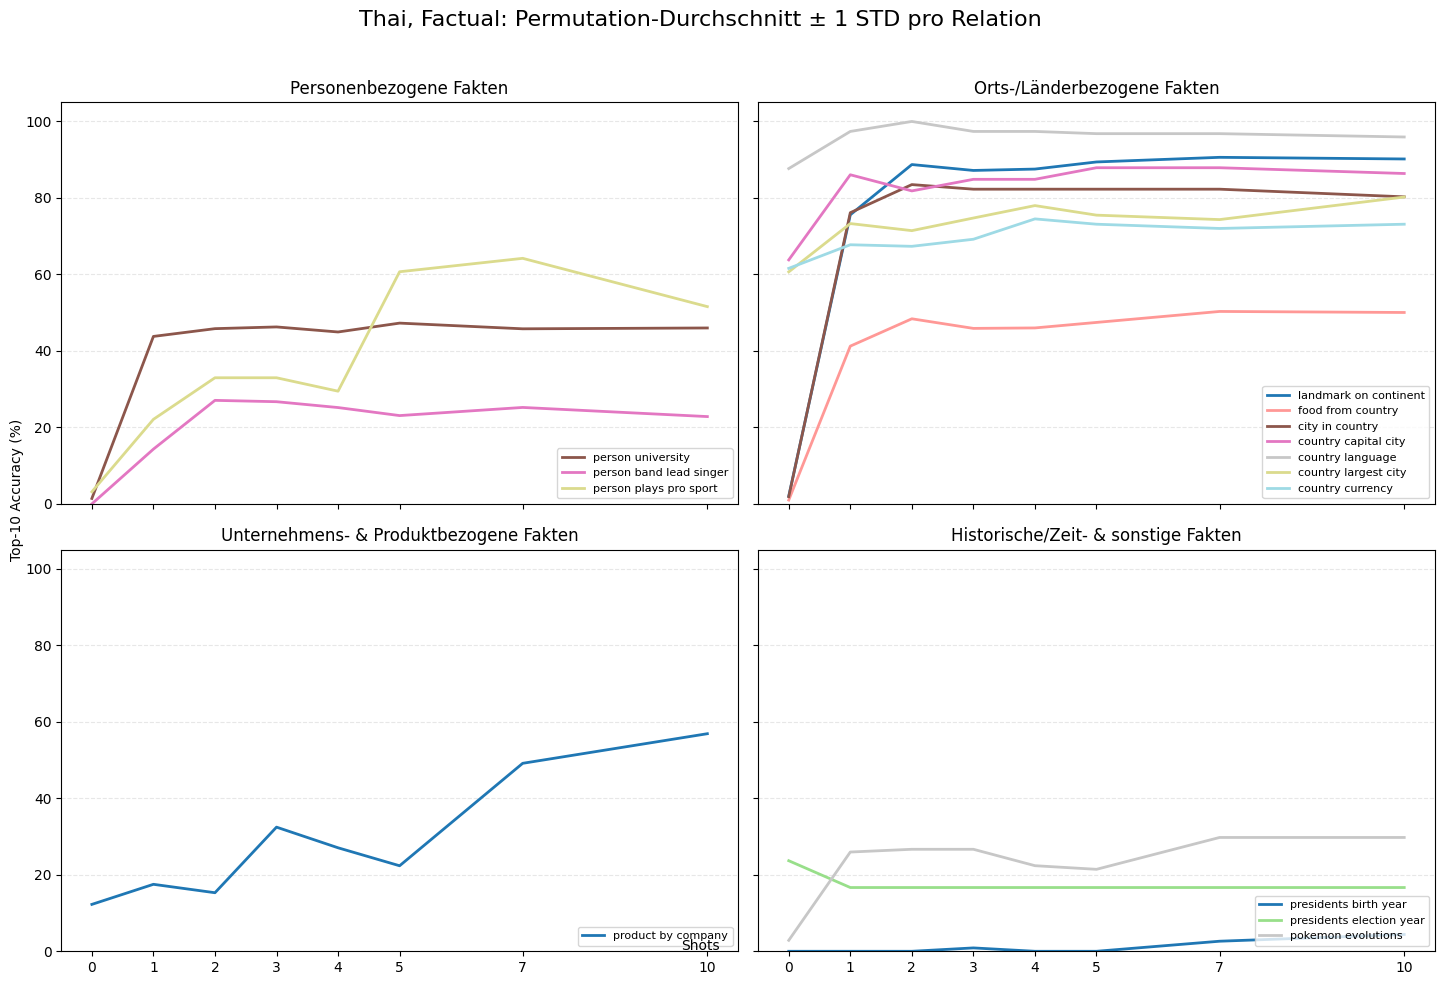

In [54]:
#top 10
base_dirs = {
    "few_shots_relationen": "/content/drive/MyDrive/master_thesis/dataset_multilingual/factual/th/result_10_accuracy/eval_accuracy/permutation_0"
}

plot_factual_accuracy_10(
    base_dirs,
    title="Thai, Factual: Permutation-Durchschnitt ± 1 STD pro Relation",
    save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy",
    fname="llama_th_factual_top10"
)

# Linguistic

In [ ]:
#top 1
import os, re, json
import pandas as pd
import matplotlib.pyplot as plt

def plot_accuracy_subplot(lang_dicts, save_dir=None, fname="subplot_accuracy"):
    full_shots = [0, 1, 2, 3, 4, 5, 7, 10]

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15), sharey=True)

    subplot_order = [
        ("English", "OLMo"),
        ("English", "LLaMA"),
        ("German", "LLaMA"),
        ("Spanish", "LLaMA"),
        ("French", "LLaMA"),
        ("Italian", "LLaMA"),
        ("Portuguese", "LLaMA"),
        ("Hindi", "LLaMA"),
        ("Thai", "LLaMA"),
    ]

    for idx, (lang, model) in enumerate(subplot_order):
        row, col = divmod(idx, 3)
        ax = axes[row, col]

        base_path_dict = lang_dicts[lang][model]

        records = []
        for root in base_path_dict.values():
            for rel_folder in os.listdir(root):
                rel_path = os.path.join(root, rel_folder)
                if not os.path.isdir(rel_path):
                    continue
                relation = rel_folder.replace("accuracy_", "")
                for fn in os.listdir(rel_path):
                    if not fn.endswith(".json") or re.search(r"\b0shot\b", fn, re.I):
                        continue
                    shot_match = re.search(r"(\d+)shot", fn, re.I)
                    if not shot_match:
                        continue
                    shot = int(shot_match.group(1))
                    with open(os.path.join(rel_path, fn), encoding="utf-8") as f:
                        data = json.load(f)
                    acc = data.get("top_1_accuracy") or data.get("average_top_1_accuracy")
                    if acc is None:
                        continue
                    records.append(
                        dict(Relation=relation, Shot=shot, Accuracy=float(acc))
                    )

        df = pd.DataFrame(records)
        if df.empty:
            ax.set_title(f"{model} ({lang}) – No Data")
            continue

        stats = df.groupby(["Relation", "Shot"])["Accuracy"].agg(mean="mean", std="std").reset_index()
        relations = sorted(stats["Relation"].unique())
        cmap = plt.cm.get_cmap("tab20", len(relations))
        rel2col = {rel: cmap(i) for i, rel in enumerate(relations)}

        for rel in relations:
            sub = stats[stats["Relation"] == rel].set_index("Shot").reindex(full_shots)
            mu, sig = sub["mean"], sub["std"]
            color = rel2col[rel]
            ax.fill_between(full_shots, mu - sig, mu + sig, color=color, alpha=0.3, linewidth=0)
            ax.plot(full_shots, mu, color=color, linewidth=2, label=rel.replace("_", " "))

        ax.set_xlim(full_shots[0], full_shots[-1])
        ax.set_ylim(0, 105)
        ax.set_xticks(full_shots)
        ax.set_xlabel("Shots")
        ax.set_ylabel("Top-1 Accuracy (%)")
        ax.set_title(f"{model} ({lang})")
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)

        if idx == 2:  # Legende nur im dritten Plot
            ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=12)


    plt.tight_layout(rect=(0, 0, 0.95, 0.98))


    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(os.path.join(save_dir, f"{fname}.pdf"))
        fig.savefig(os.path.join(save_dir, f"{fname}.png"), dpi=300)

    plt.show()
    plt.close(fig)


/tmp/ipython-input-12-3094865383.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(relations))
/tmp/ipython-input-12-3094865383.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(relations))
/tmp/ipython-input-12-3094865383.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(relations))
/tmp/ipython-input-12-3094865383.py:58: MatplotlibDeprecationWar

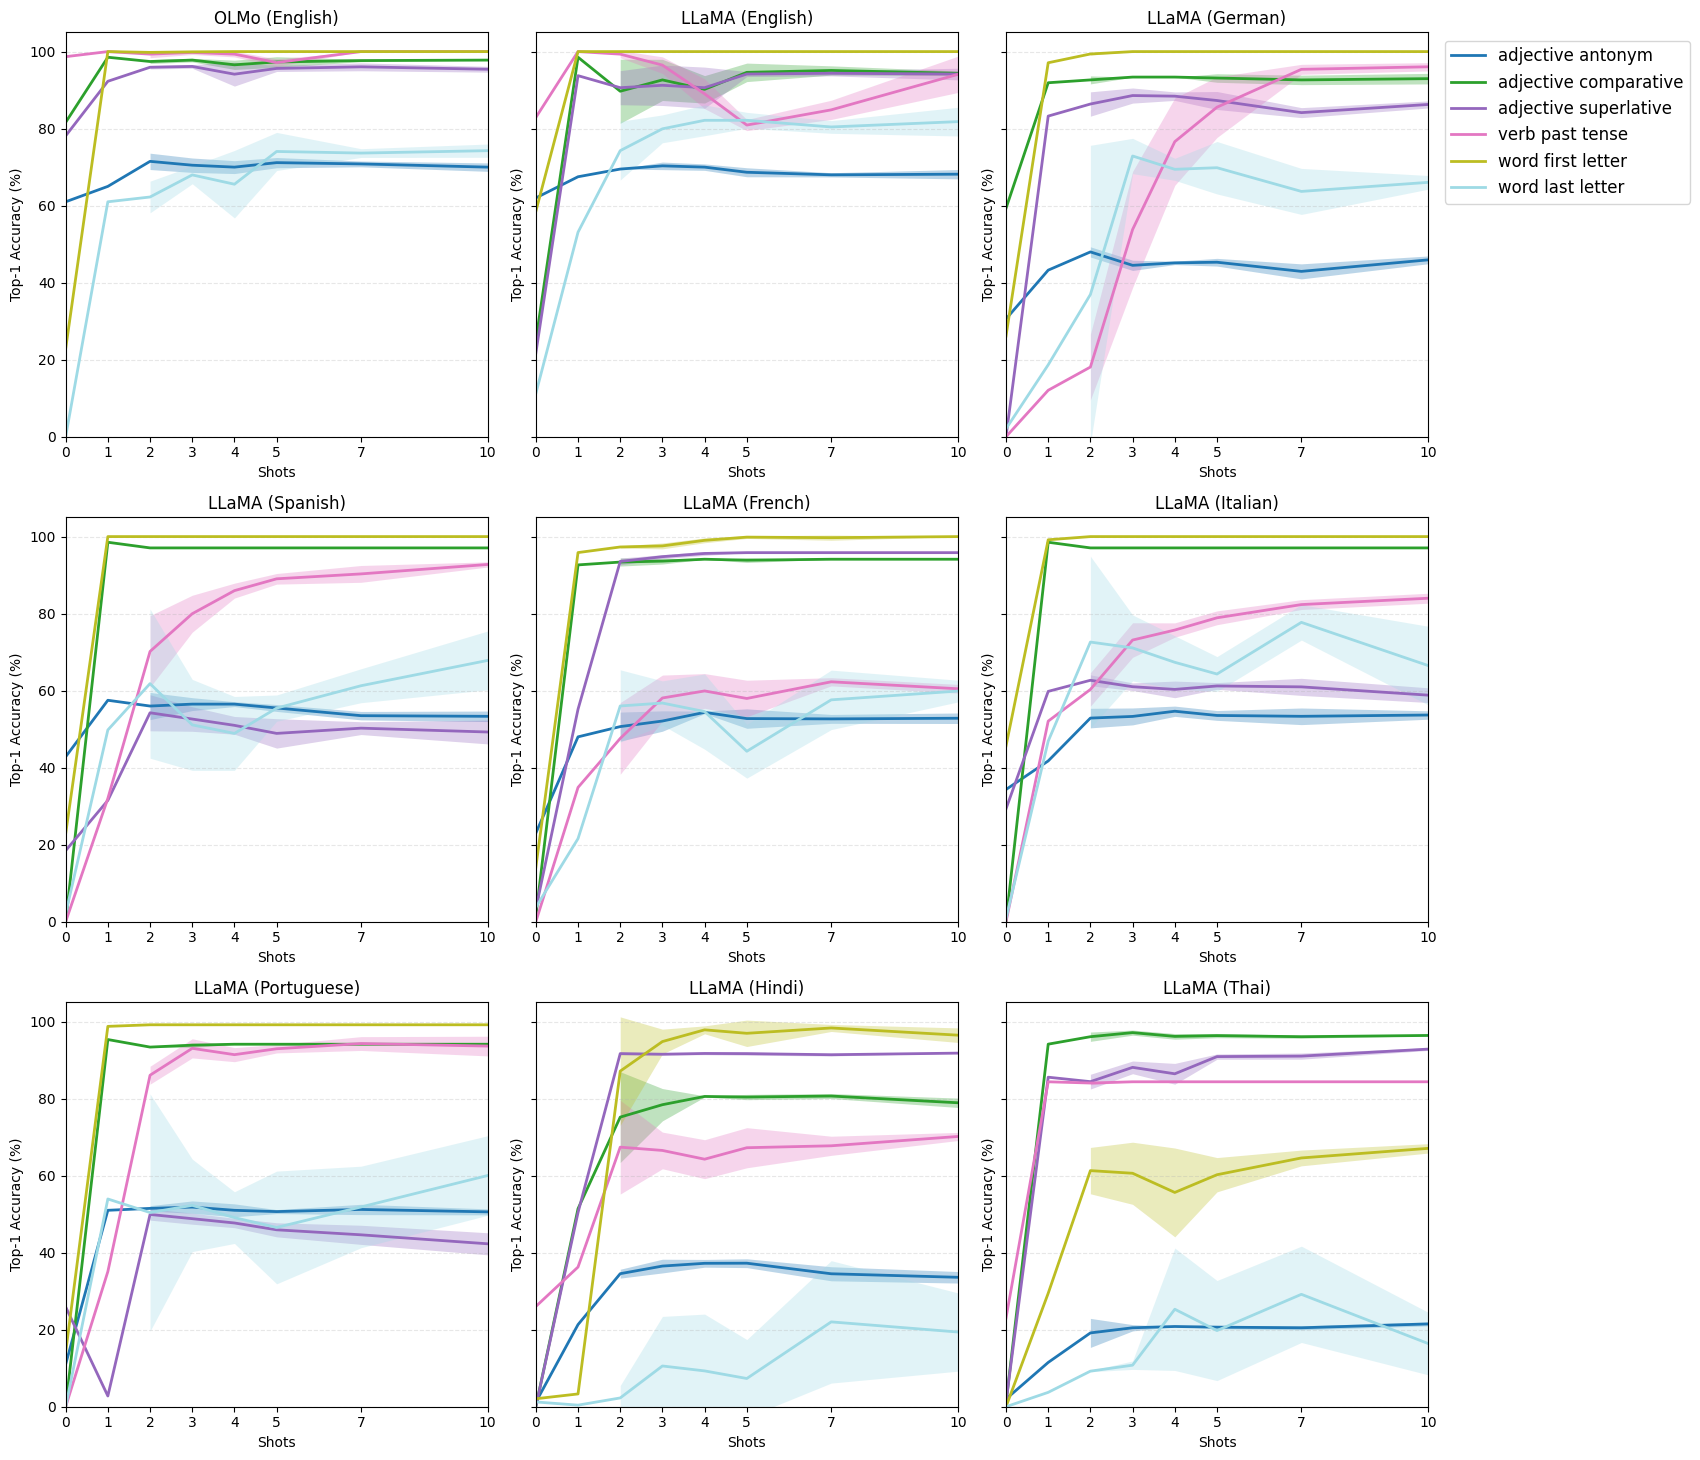

In [ ]:
# all languages

lang_dicts = {
    "English": {
        "OLMo": {
            "perm_0": "/content/drive/MyDrive/master_thesis/data/linguistic_data/few_shots_final/result/eval_accuracy_olmo/permutation_0",
            "perm_1": "/content/drive/MyDrive/master_thesis/data/linguistic_data/few_shots_final/result/eval_accuracy_olmo/permutation_1",
            "perm_2": "/content/drive/MyDrive/master_thesis/data/linguistic_data/few_shots_final/result/eval_accuracy_olmo/permutation_2",
            "perm_3": "/content/drive/MyDrive/master_thesis/data/linguistic_data/few_shots_final/result/eval_accuracy_olmo/permutation_3",
            "perm_4": "/content/drive/MyDrive/master_thesis/data/linguistic_data/few_shots_final/result/eval_accuracy_olmo/permutation_4",
            "perm_5": "/content/drive/MyDrive/master_thesis/data/linguistic_data/few_shots_final/result/eval_accuracy_olmo/permutation_5"
        },
        "LLaMA": {
            "perm_0": "/content/drive/MyDrive/master_thesis/data/linguistic_data/few_shots_final/result_new/eval_accuracy/permutation_0",
            "perm_1": "/content/drive/MyDrive/master_thesis/data/linguistic_data/few_shots_final/result_new/eval_accuracy/permutation_1",
            "perm_2": "/content/drive/MyDrive/master_thesis/data/linguistic_data/few_shots_final/result_new/eval_accuracy/permutation_2",
            "perm_3": "/content/drive/MyDrive/master_thesis/data/linguistic_data/few_shots_final/result_new/eval_accuracy/permutation_3",
            "perm_4": "/content/drive/MyDrive/master_thesis/data/linguistic_data/few_shots_final/result_new/eval_accuracy/permutation_4",
            "perm_5": "/content/drive/MyDrive/master_thesis/data/linguistic_data/few_shots_final/result_new/eval_accuracy/permutation_5"
        }

    },
    "German": {
        "LLaMA": {
            "perm_0": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/de/result_new/eval_accuracy/permutation_0",
            "perm_1": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/de/result_new/eval_accuracy/permutation_1",
            "perm_2": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/de/result_new/eval_accuracy/permutation_2",
            "perm_3": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/de/result_new/eval_accuracy/permutation_3",
            "perm_4": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/de/result_new/eval_accuracy/permutation_4",
            "perm_5": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/de/result_new/eval_accuracy/permutation_5"
        }
    },
    "Spanish": {
        "LLaMA": {
            "perm_0": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/es/result_new/eval_accuracy/permutation_0",
            "perm_1": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/es/result_new/eval_accuracy/permutation_1",
            "perm_2": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/es/result_new/eval_accuracy/permutation_2",
            "perm_3": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/es/result_new/eval_accuracy/permutation_3",
            "perm_4": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/es/result_new/eval_accuracy/permutation_4",
            "perm_5": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/es/result_new/eval_accuracy/permutation_5"

            }
    },

    "French": {
        "LLaMA": {
            "perm_0": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/fr/result_new/eval_accuracy/permutation_0",
            "perm_1": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/fr/result_new/eval_accuracy/permutation_1",
            "perm_2": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/fr/result_new/eval_accuracy/permutation_2",
            "perm_3": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/fr/result_new/eval_accuracy/permutation_3",
            "perm_4": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/fr/result_new/eval_accuracy/permutation_4",
            "perm_5": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/fr/result_new/eval_accuracy/permutation_5"
        }
    },

    "Italian": {
        "LLaMA": {
            "perm_0": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/it/result_10_accuracy/eval_accuracy/permutation_0",
            "perm_1": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/it/result_new/eval_accuracy/permutation_1",
            "perm_2": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/it/result_new/eval_accuracy/permutation_2",
            "perm_3": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/it/result_new/eval_accuracy/permutation_3",
            "perm_4": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/it/result_new/eval_accuracy/permutation_4",
            "perm_5": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/it/result_new/eval_accuracy/permutation_5"
        }
    },
    "Portuguese": {
        "LLaMA": {
            "perm_0": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/pt/result_new/eval_accuracy/permutation_0",
            "perm_1": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/pt/result_new/eval_accuracy/permutation_1",
            "perm_2": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/pt/result_new/eval_accuracy/permutation_2",
            "perm_3": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/pt/result_new/eval_accuracy/permutation_3",
            "perm_4": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/pt/result_new/eval_accuracy/permutation_4",
            "perm_5": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/pt/result_new/eval_accuracy/permutation_5"
        }
    },
    "Hindi": {
        "LLaMA": {
            "perm_0": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/hi/result_10_accuracy/eval_accuracy/permutation_0",
            "perm_1": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/hi/result_10_accuracy/eval_accuracy/permutation_1",
            "perm_2": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/hi/result_10_accuracy/eval_accuracy/permutation_2",
            "perm_3": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/hi/result_10_accuracy/eval_accuracy/permutation_3",
            "perm_4": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/hi/result_10_accuracy/eval_accuracy/permutation_4",
            "perm_5": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/hi/result_10_accuracy/eval_accuracy/permutation_5"
        }
    },
    "Thai": {
        "LLaMA": {
            "perm_0": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/th/result_10_accuracy/eval_accuracy/permutation_0",
            "perm_1": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/th/result_10_accuracy/eval_accuracy/permutation_1",
            "perm_2": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/th/result_10_accuracy/eval_accuracy/permutation_2",
            "perm_3": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/th/result_10_accuracy/eval_accuracy/permutation_3",
            "perm_4": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/th/result_10_accuracy/eval_accuracy/permutation_4",
            "perm_5": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/th/result_10_accuracy/eval_accuracy/permutation_5"
            # ...
        }
    }
}

plot_accuracy_subplot(lang_dicts, save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy", fname="final_subplot_comparison")


In [5]:
#top 10
import os, re, json
import pandas as pd
import matplotlib.pyplot as plt

def plot_accuracy_subplot_li_10(lang_dicts, save_dir=None, fname="subplot_accuracy"):
    full_shots = [0, 1, 2, 3, 4, 5, 7, 10]

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15), sharey=True)

    subplot_order = [
        ("English", "OLMo"),
        ("English", "LLaMA"),
        ("German", "LLaMA"),
        ("Spanish", "LLaMA"),
        ("French", "LLaMA"),
        ("Italian", "LLaMA"),
        ("Portuguese", "LLaMA"),
        ("Hindi", "LLaMA"),
        ("Thai", "LLaMA"),
    ]

    for idx, (lang, model) in enumerate(subplot_order):
        row, col = divmod(idx, 3)
        ax = axes[row, col]

        base_path_dict = lang_dicts[lang][model]

        records = []
        for root in base_path_dict.values():
            for rel_folder in os.listdir(root):
                rel_path = os.path.join(root, rel_folder)
                if not os.path.isdir(rel_path):
                    continue
                relation = rel_folder.replace("accuracy_", "")
                for fn in os.listdir(rel_path):
                    if not fn.endswith(".json") or re.search(r"\b0shot\b", fn, re.I):
                        continue
                    shot_match = re.search(r"(\d+)shot", fn, re.I)
                    if not shot_match:
                        continue
                    shot = int(shot_match.group(1))
                    with open(os.path.join(rel_path, fn), encoding="utf-8") as f:
                        data = json.load(f)
                    acc = data.get("top_10_accuracy") or data.get("average_top_10_accuracy")
                    if acc is None:
                        continue
                    records.append(
                        dict(Relation=relation, Shot=shot, Accuracy=float(acc))
                    )

        df = pd.DataFrame(records)
        if df.empty:
            ax.set_title(f"{model} ({lang}) – No Data")
            continue

        stats = df.groupby(["Relation", "Shot"])["Accuracy"].agg(mean="mean", std="std").reset_index()
        relations = sorted(stats["Relation"].unique())
        cmap = plt.cm.get_cmap("tab20", len(relations))
        rel2col = {rel: cmap(i) for i, rel in enumerate(relations)}

        for rel in relations:
            sub = stats[stats["Relation"] == rel].set_index("Shot").reindex(full_shots)
            mu, sig = sub["mean"], sub["std"]
            color = rel2col[rel]
            ax.fill_between(full_shots, mu - sig, mu + sig, color=color, alpha=0.3, linewidth=0)
            ax.plot(full_shots, mu, color=color, linewidth=2, label=rel.replace("_", " "))

        ax.set_xlim(full_shots[0], full_shots[-1])
        ax.set_ylim(0, 105)
        ax.set_xticks(full_shots)
        ax.set_xlabel("Shots")
        ax.set_ylabel("Top-10 Accuracy (%)")
        ax.set_title(f"{model} ({lang})")
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)

        if idx == 2:  # Legende nur im dritten Plot
            ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=12)


    plt.tight_layout(rect=(0, 0, 0.95, 0.98))


    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(os.path.join(save_dir, f"{fname}.pdf"))
        fig.savefig(os.path.join(save_dir, f"{fname}.png"), dpi=300)

    plt.show()
    plt.close(fig)


/tmp/ipython-input-5-1137788035.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(relations))
/tmp/ipython-input-5-1137788035.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(relations))
/tmp/ipython-input-5-1137788035.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(relations))
/tmp/ipython-input-5-1137788035.py:59: MatplotlibDeprecationWarning

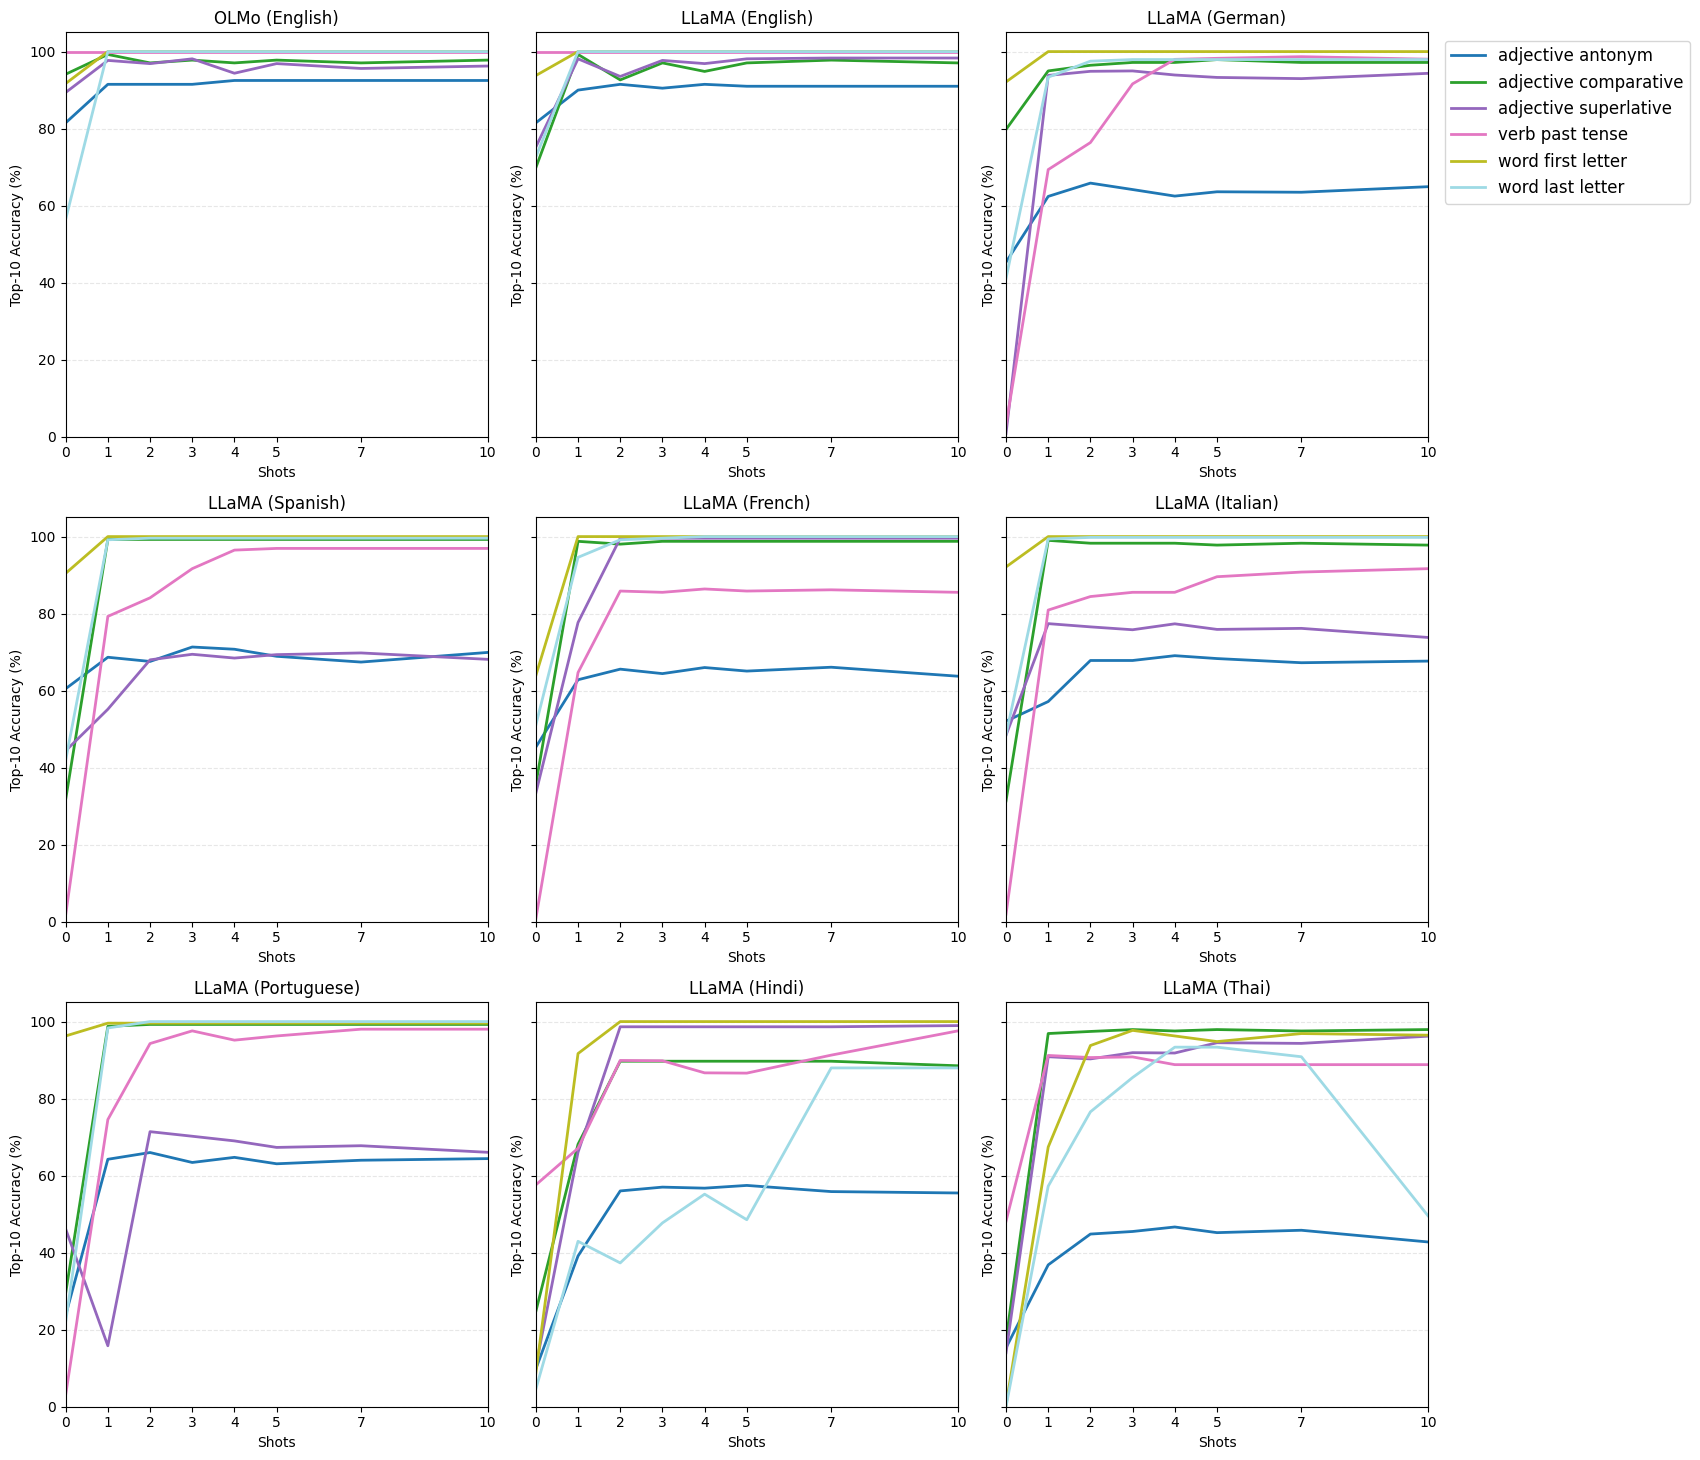

In [7]:
# top 10

lang_dicts = {
    "English": {
        "OLMo": {
            "perm_0": "/content/drive/MyDrive/master_thesis/data/linguistic_data/few_shots_final/result_10_accuracy/eval_accuracy_ollmo/permutation_0"
        },
        "LLaMA": {
            "perm_0": "/content/drive/MyDrive/master_thesis/data/linguistic_data/few_shots_final/result_10_accuracy/eval_accuracy/permutation_0"
        }

    },
    "German": {
        "LLaMA": {
            "perm_0": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/de/result_10_accuracy/eval_accuracy/permutation_0"
        }
    },
    "Spanish": {
        "LLaMA": {
            "perm_0": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/es/result_10_accuracy/eval_accuracy/permutation_0"

            }
    },

    "French": {
        "LLaMA": {
            "perm_0": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/fr/result_10_accuracy/eval_accuracy/permutation_0"
        }
    },

    "Italian": {
        "LLaMA": {
            "perm_0": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/it/result_10_accuracy/eval_accuracy/permutation_0"
        }
    },
    "Portuguese": {
        "LLaMA": {
            "perm_0": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/pt/result_10_accuracy/eval_accuracy/permutation_0"
        }
    },
    "Hindi": {
        "LLaMA": {
            "perm_0": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/hi/result_10_accuracy/eval_accuracy/permutation_0"
        }
    },
    "Thai": {
        "LLaMA": {
            "perm_0": "/content/drive/MyDrive/master_thesis/dataset_multilingual/linguistic/th/result_10_accuracy/eval_accuracy/permutation_0"

        }
    }
}

plot_accuracy_subplot_li_10(lang_dicts, save_dir="/content/drive/MyDrive/master_thesis/ploted_data/accuracy", fname="final_subplot_comparison")
